In [1]:
from sklearn import ensemble, linear_model, metrics, model_selection

import catboost
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings

In [2]:
df = pd.read_csv("AAVEUSDT (1).csv", parse_dates=[0])
df.shape

(931565, 22)

# Data exploration and missing value filling

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931565 entries, 0 to 931564
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 931565 non-null  datetime64[ns]
 1   close                931565 non-null  float64       
 2   volume               931565 non-null  float64       
 3   spread               931563 non-null  float64       
 4   mr_strength_ar_100   931365 non-null  float64       
 5   half_life_ar_100     901263 non-null  float64       
 6   theta_100            931362 non-null  float64       
 7   half_life_ou_100     931362 non-null  float64       
 8   hurst_100            931365 non-null  float64       
 9   adf_p_100            931365 non-null  float64       
 10  kpss_p_100           931365 non-null  float64       
 11  var_ratio_100        931365 non-null  float64       
 12  rs_ratio_100         931365 non-null  float64       
 13  mr_strength_ar

In [4]:
df.head().T

,0,1,2,3,4
date,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00
close,51.97,51.96,51.93,51.92,51.94
volume,26017.699,19181.147,6544.709,6101.511,15391.479
spread,-5.762749,-5.762754,-5.76312,-5.763041,-5.762795
mr_strength_ar_100,NaN,NaN,NaN,NaN,NaN
half_life_ar_100,NaN,NaN,NaN,NaN,NaN
theta_100,NaN,NaN,NaN,NaN,NaN
half_life_ou_100,NaN,NaN,NaN,NaN,NaN
hurst_100,NaN,NaN,NaN,NaN,NaN
adf_p_100,NaN,NaN,NaN,NaN,NaN


Check the differences between consecutive date values:

In [5]:
(df['date'].diff(1).dt.total_seconds() / 60).value_counts()

date
1.0     931474
2.0         83
3.0          5
19.0         1
5.0          1
Name: count, dtype: int64

In [6]:
df[np.abs(df['date'].diff(1).dt.total_seconds() - 60) > 0.1]['date'].dt.date.unique()

array([datetime.date(2023, 4, 10), datetime.date(2023, 4, 29),
       datetime.date(2023, 5, 14), datetime.date(2023, 5, 17),
       datetime.date(2023, 5, 21), datetime.date(2023, 5, 22),
       datetime.date(2023, 5, 27), datetime.date(2023, 6, 2),
       datetime.date(2023, 6, 3), datetime.date(2023, 6, 4),
       datetime.date(2023, 6, 6), datetime.date(2023, 6, 14),
       datetime.date(2023, 6, 20), datetime.date(2023, 6, 23),
       datetime.date(2023, 7, 25), datetime.date(2023, 8, 6),
       datetime.date(2023, 8, 15), datetime.date(2023, 8, 18),
       datetime.date(2023, 8, 19), datetime.date(2023, 8, 20),
       datetime.date(2023, 8, 23), datetime.date(2023, 8, 26),
       datetime.date(2023, 8, 27), datetime.date(2023, 8, 30),
       datetime.date(2023, 9, 1), datetime.date(2023, 9, 2),
       datetime.date(2023, 9, 3), datetime.date(2023, 9, 4),
       datetime.date(2023, 9, 5), datetime.date(2023, 9, 6),
       datetime.date(2023, 9, 7), datetime.date(2023, 9, 8),
     

As there are negligible amounts of such anomalies, to make data more consistent we can input the missing points with forward imputting without much trouble:

In [7]:
# total amount of points we are adding
(df['date'].max() - df['date'].min()).total_seconds() / 60 + 1 - df.shape[0]

115.0

In [8]:
new_idx = pd.date_range(df['date'].min(), df['date'].max(), freq='1min')
df = df.set_index('date').reindex(new_idx, method='ffill')
df

,close,volume,spread,mr_strength_ar_100,half_life_ar_100,theta_100,half_life_ou_100,hurst_100,adf_p_100,kpss_p_100,...,rs_ratio_100,mr_strength_ar_1000,half_life_ar_1000,theta_1000,half_life_ou_1000,hurst_1000,adf_p_1000,kpss_p_1000,var_ratio_1000,rs_ratio_1000
2023-01-01 00:00:00,51.97,26017.699,-5.762749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:01:00,51.96,19181.147,-5.762754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:02:00,51.93,6544.709,-5.763120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:03:00,51.92,6101.511,-5.763041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:04:00,51.94,15391.479,-5.762795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-08 23:55:00,143.11,34769.351,-6.073768,0.045703,15.166275,0.100001,6.931380,1.675312,0.473324,0.010000,...,45.158988,0.009611,72.123254,0.100002,6.931361,1.491791,0.190745,0.01,0.995745,399.044731
2024-10-08 23:56:00,143.09,31604.545,-6.073641,0.046123,15.028185,0.104888,6.608469,1.674431,0.471771,0.013829,...,45.195452,0.009638,71.921129,0.100002,6.931360,1.497093,0.188947,0.01,0.992044,398.800214
2024-10-08 23:57:00,143.14,20553.896,-6.073386,0.038190,18.149921,0.100001,6.931395,1.673937,0.603775,0.018363,...,45.244417,0.009865,70.261258,0.100002,6.931358,1.501659,0.171052,0.01,0.988553,398.540896
2024-10-08 23:58:00,143.13,25817.008,-6.073455,0.039528,17.535388,0.105396,6.576577,1.661102,0.580512,0.021545,...,45.244383,0.009940,69.731497,0.100002,6.931357,1.503903,0.165960,0.01,0.982346,398.262231


In [9]:
(pd.Series(df.index).diff(1).dt.total_seconds() / 60).value_counts()

1.0    931679
Name: count, dtype: int64

Next we check distributions of NaN values with relation to time:

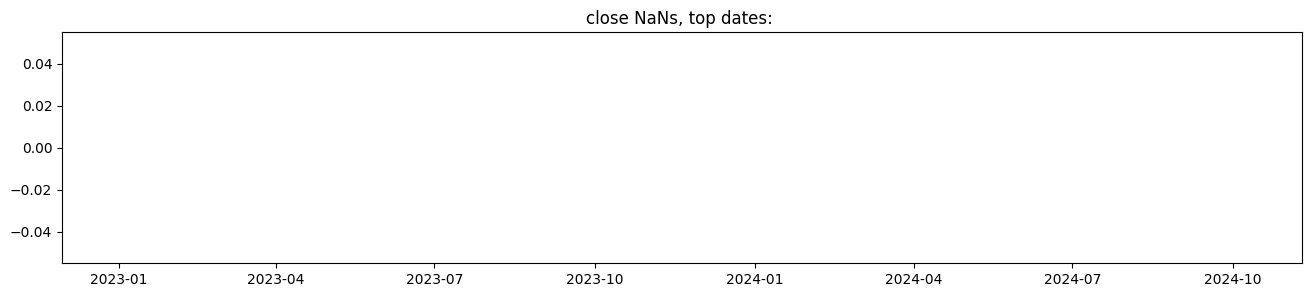

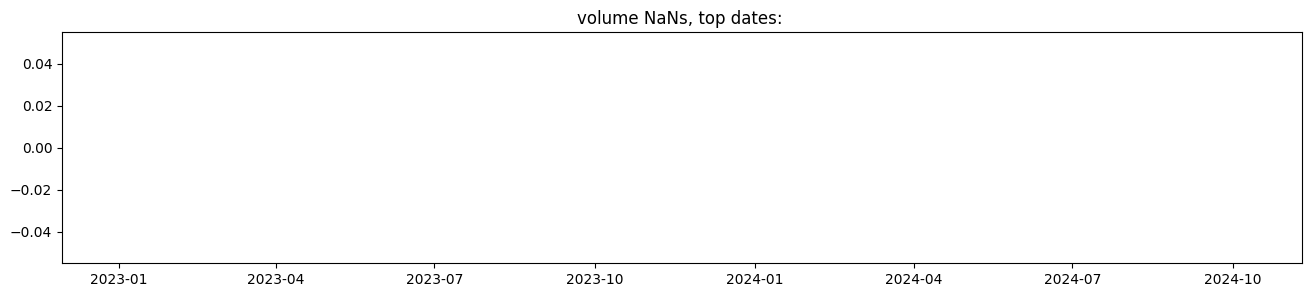

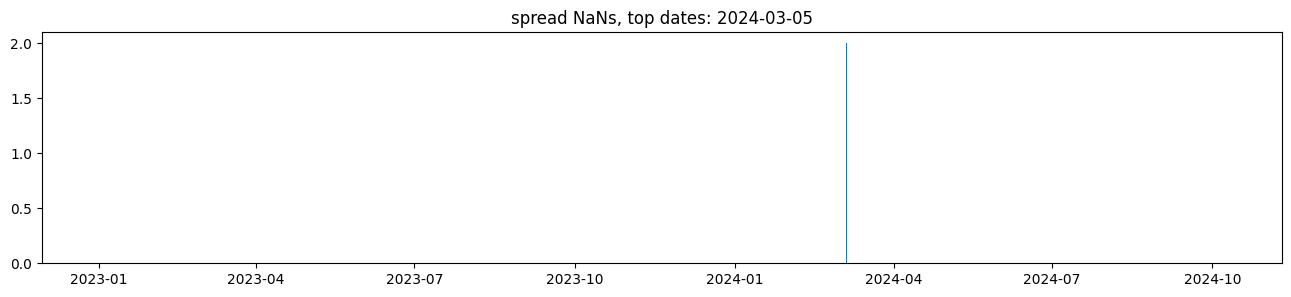

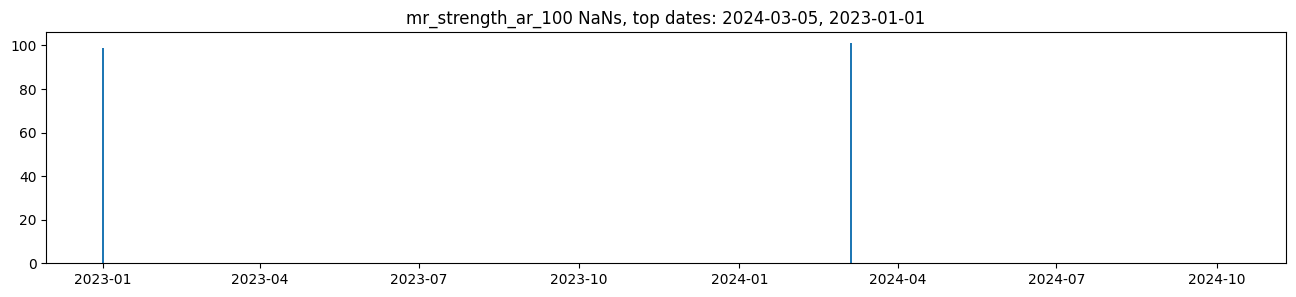

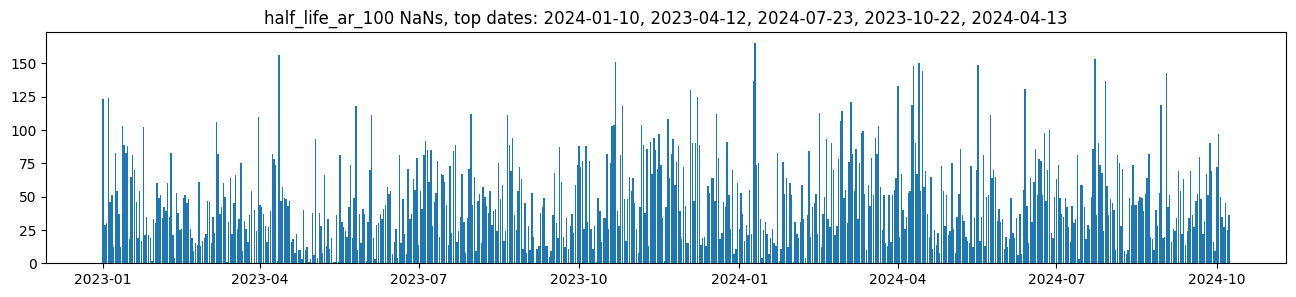

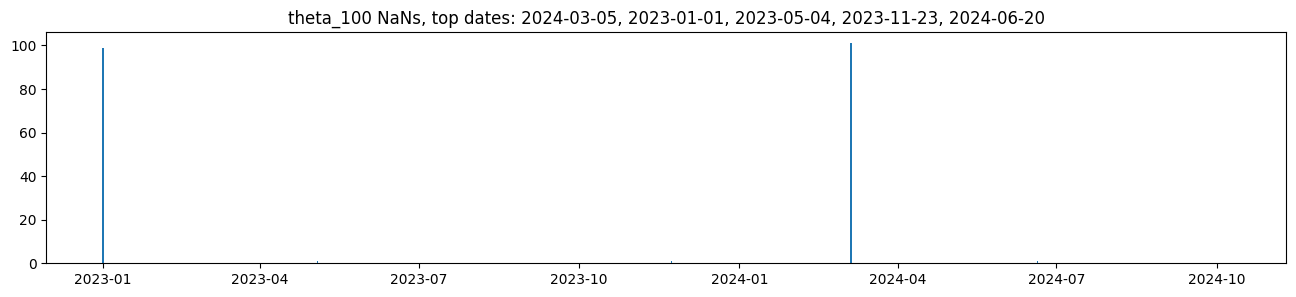

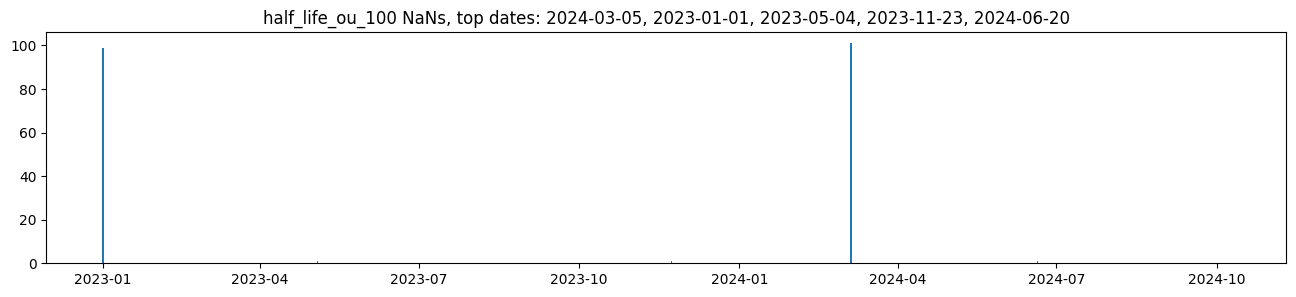

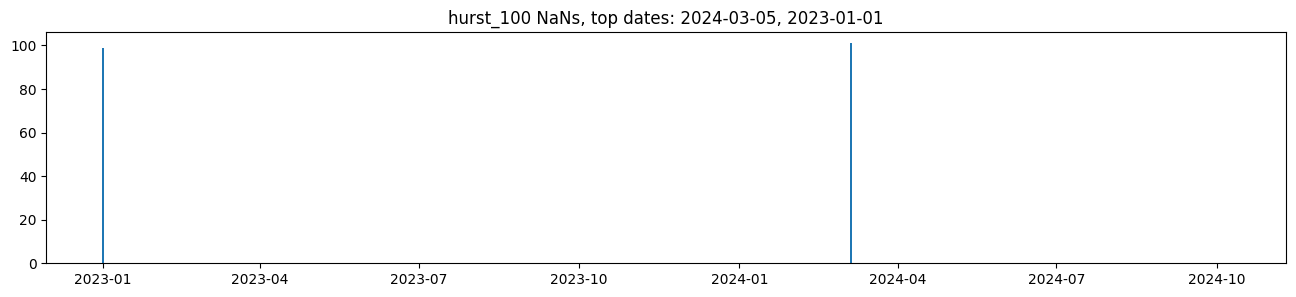

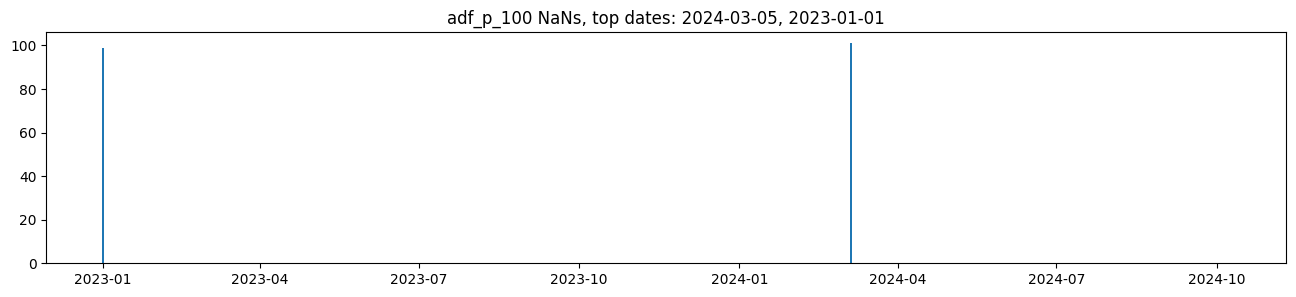

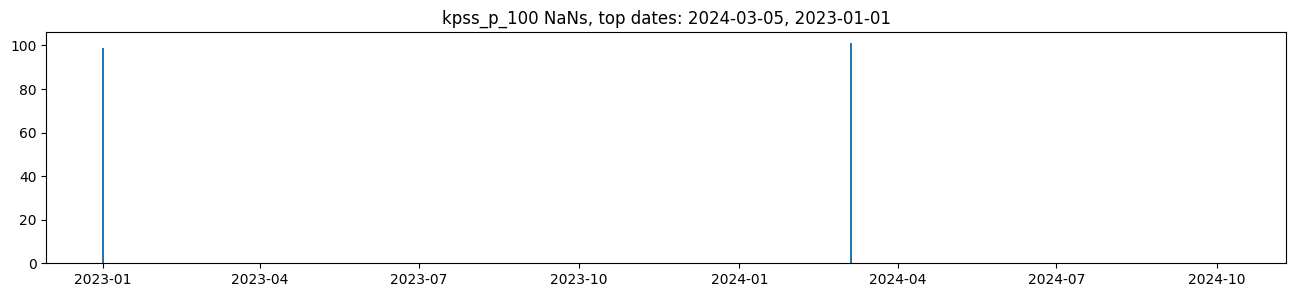

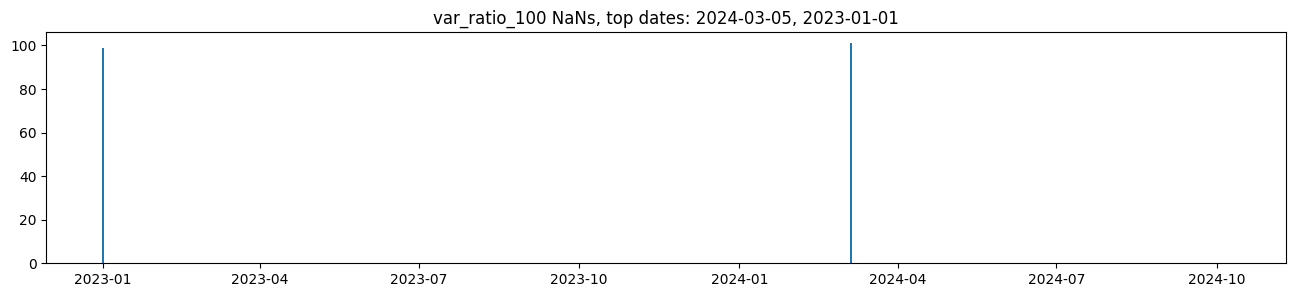

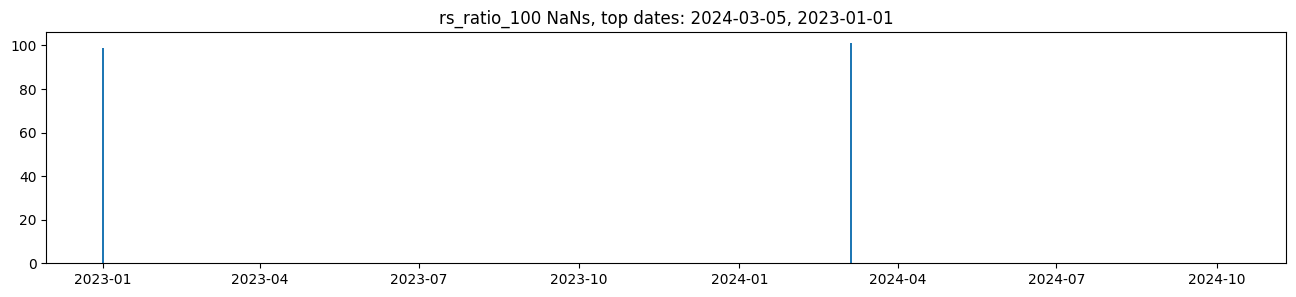

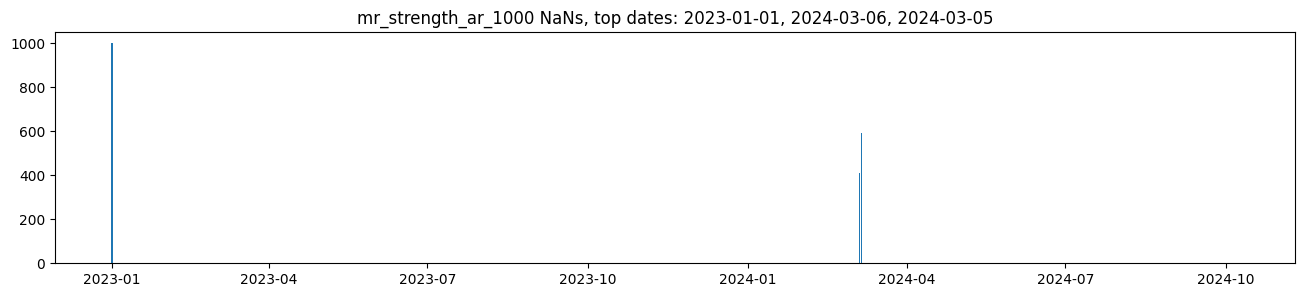

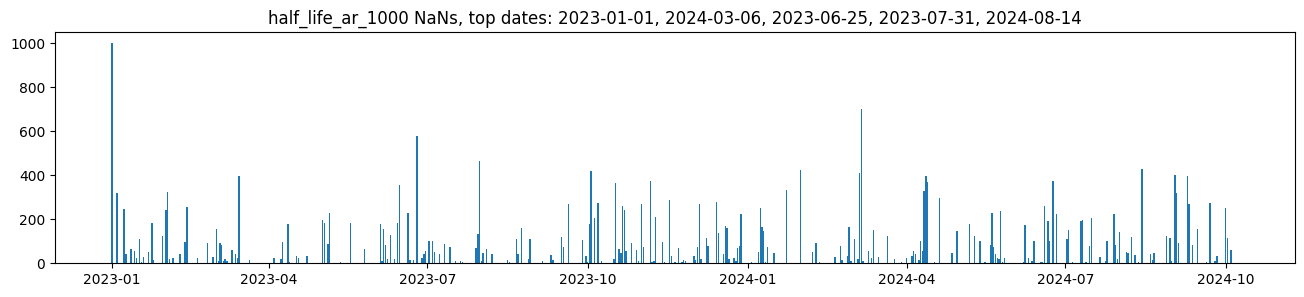

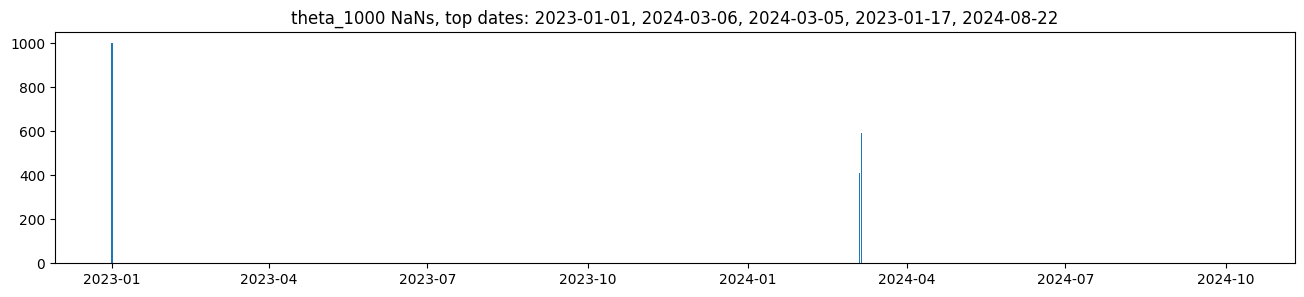

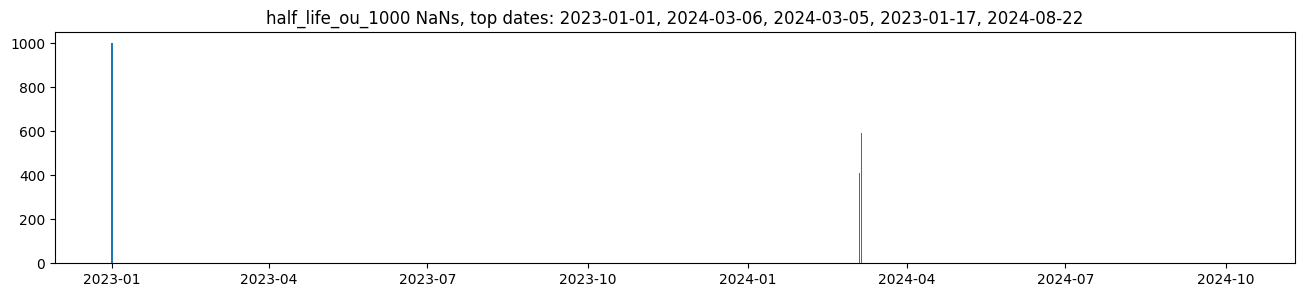

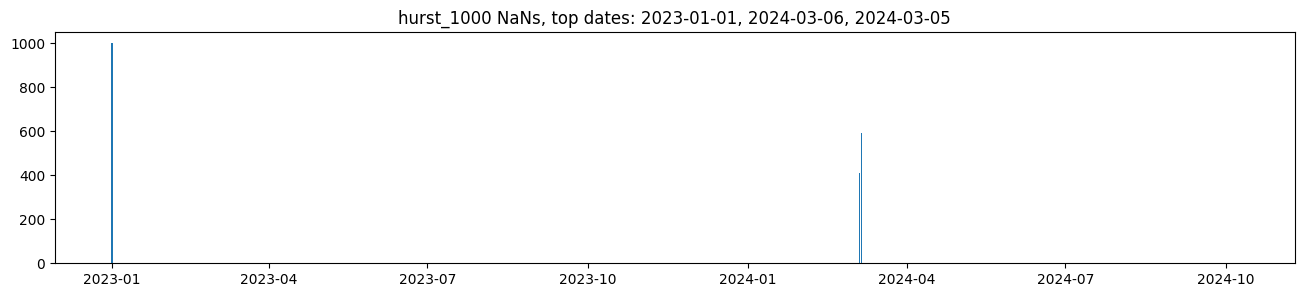

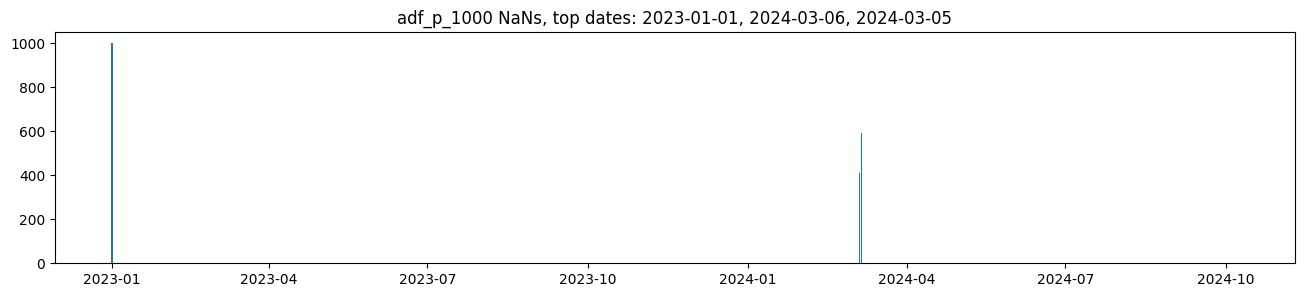

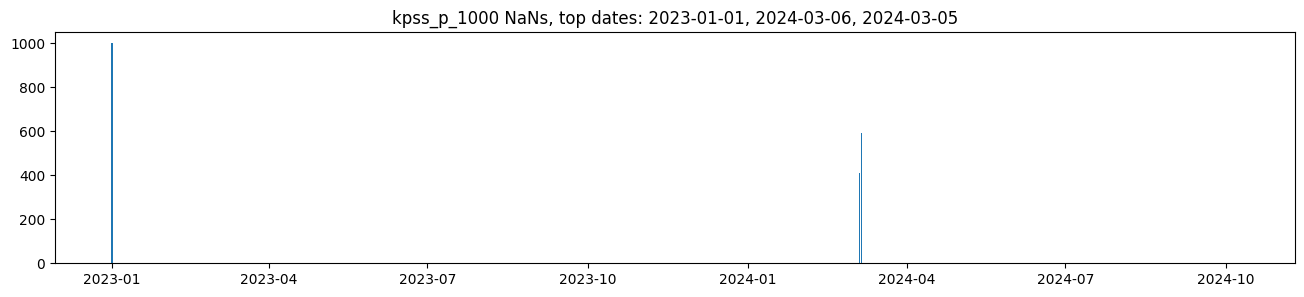

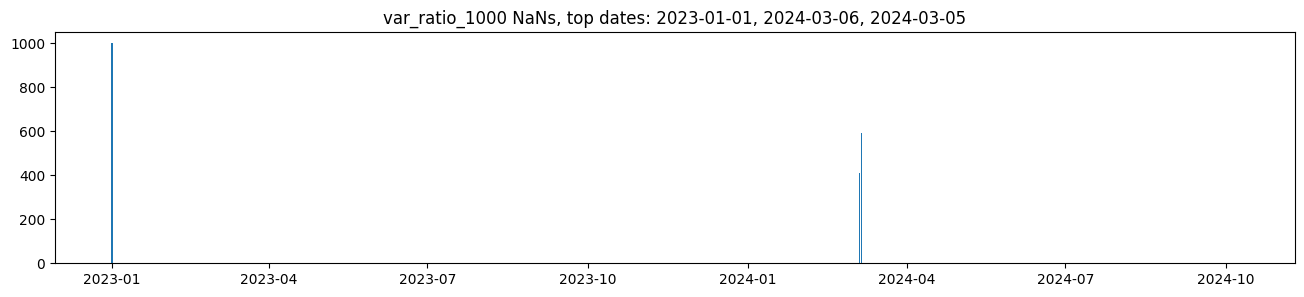

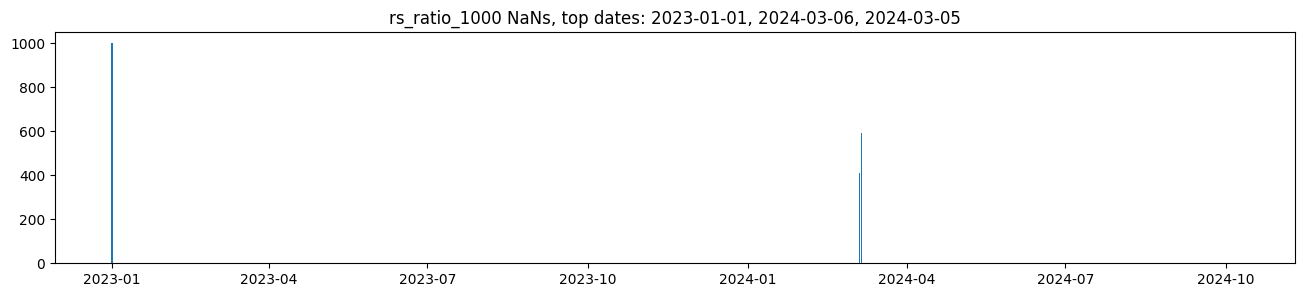

In [10]:
date_index = pd.to_datetime(df.index.date)
for col in df.columns:
    plt.figure(figsize=(16, 3))
    group = df[col].isna().astype("int").groupby(date_index).sum()
    plt.bar(group.index, group.values)
    plt.title(col + " NaNs, top dates: " + ", ".join([str(x) for x in group[group != 0].sort_values(ascending=False)[:5].index.date]))
    plt.show()

Fix the NaNs in target variable: we can just forward fill them again, as there are only 2 of them:

In [11]:
df['spread'] = df['spread'].ffill()

For the vast majority of features (all of them except two half_life_ar metrics) there are either NaNs at the beginning, which we will remove at training, or negligible amounts on several days - those we can safely ffill again. For the two NaN-heavy features we fill the columns with zeros and add a binary feature "is_nan":

In [12]:
for col in df.columns[3:]:
    if "half_life_ar" in col:
        df[col + '_is_nan'] = df[col].isna().astype(int)
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].ffill()

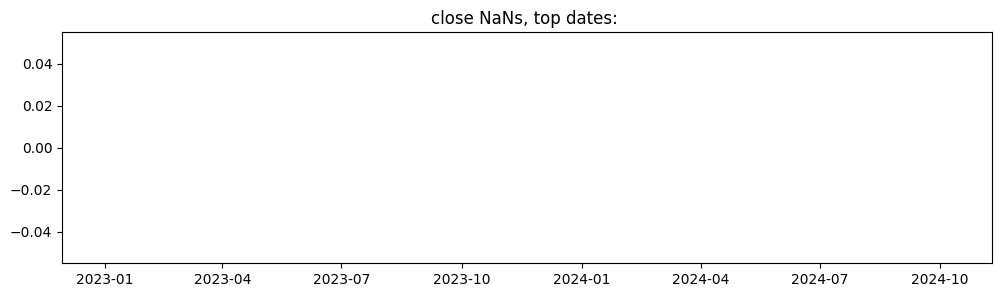

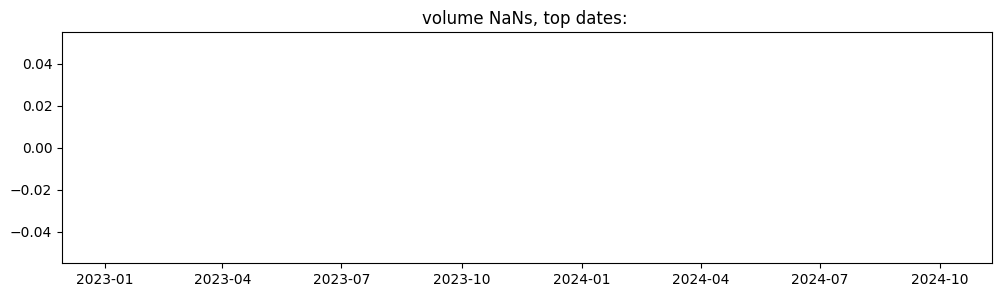

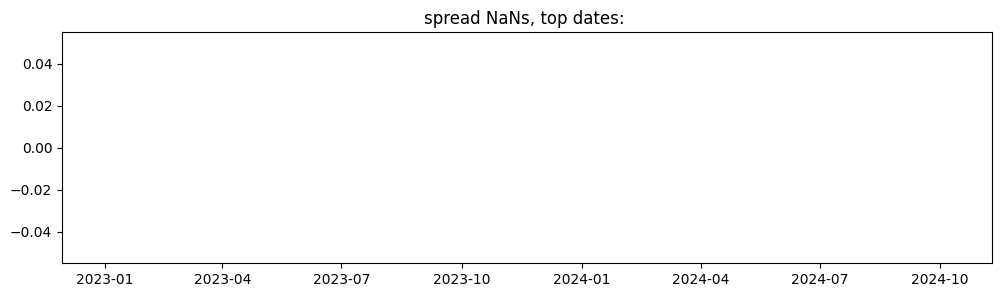

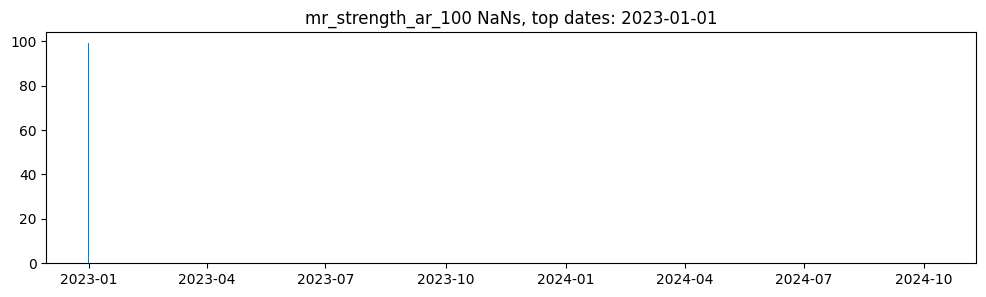

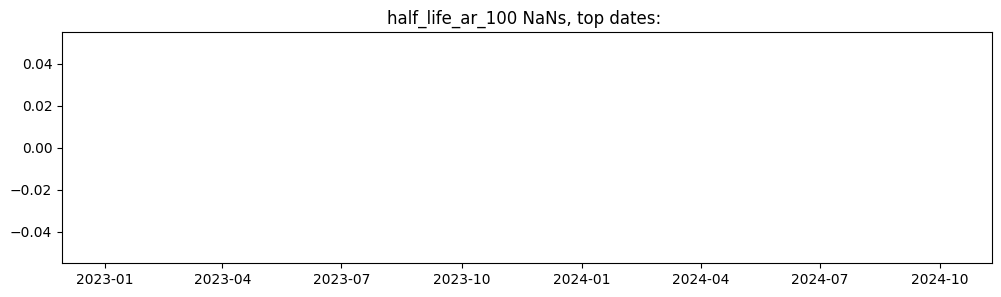

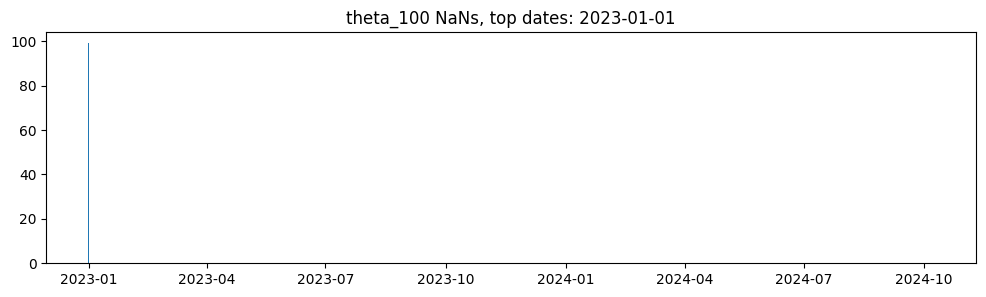

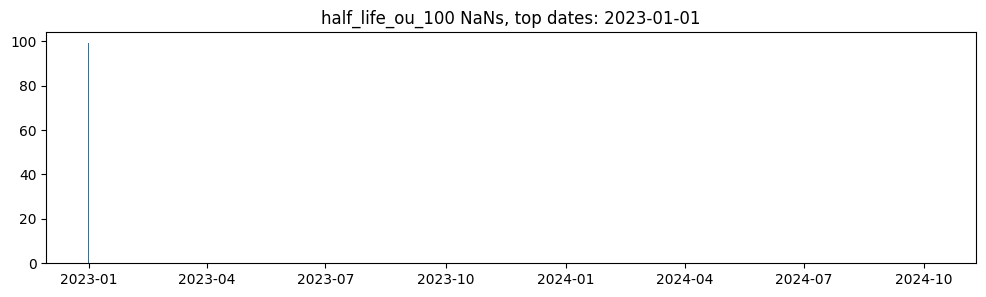

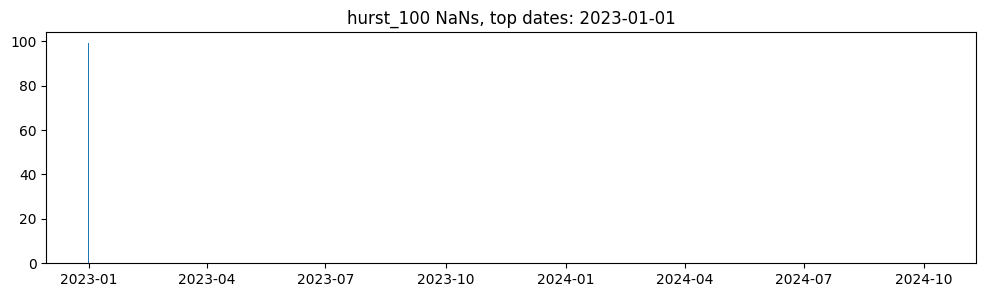

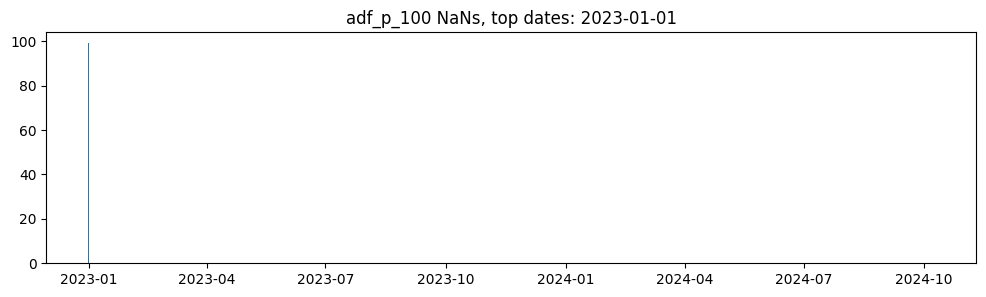

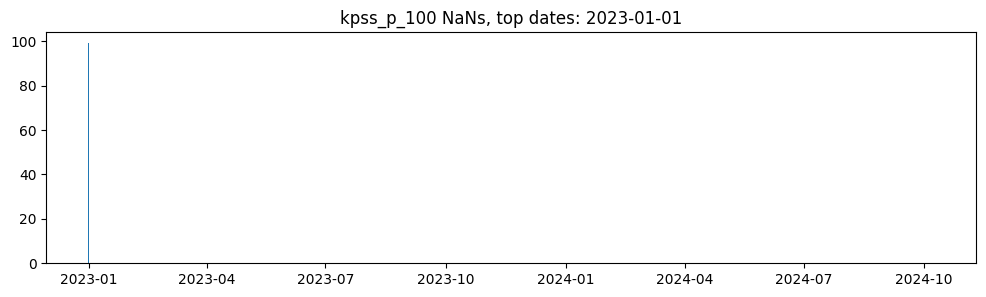

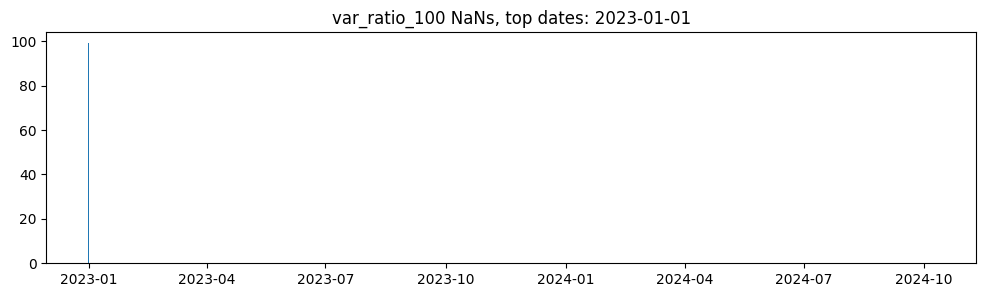

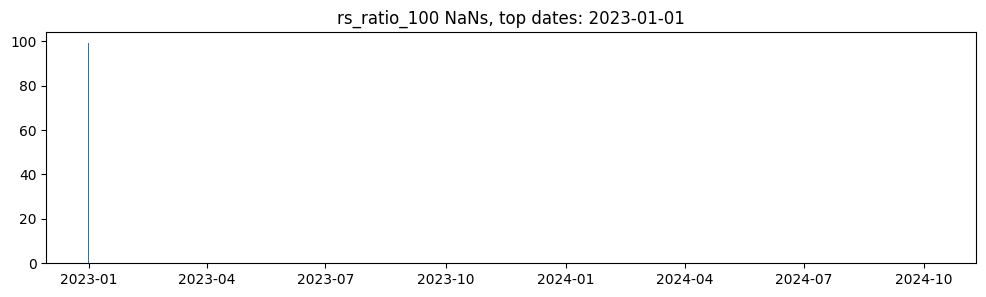

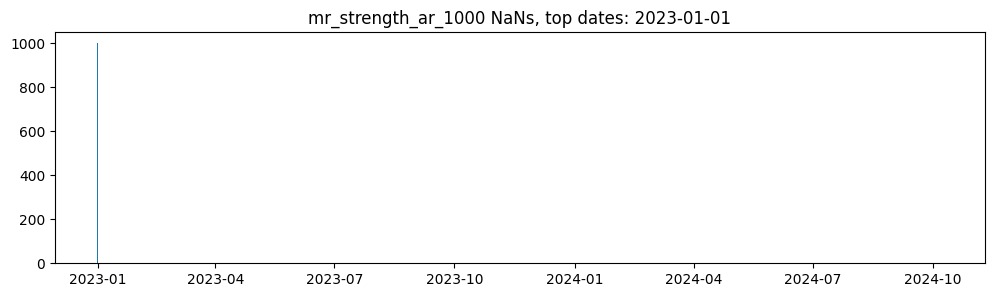

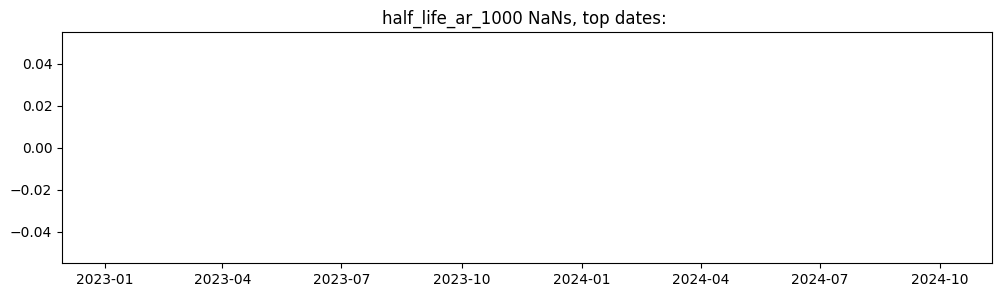

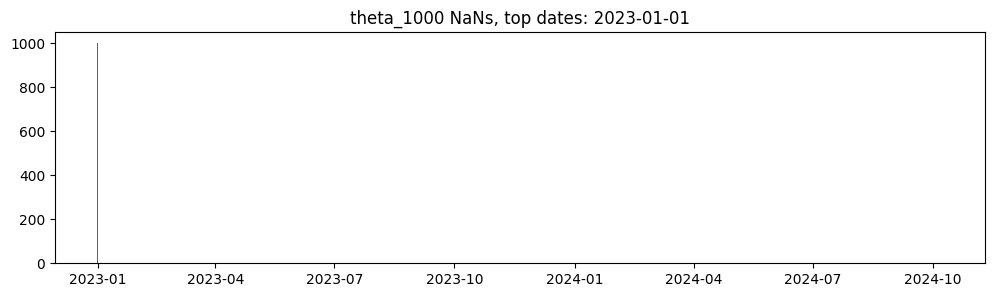

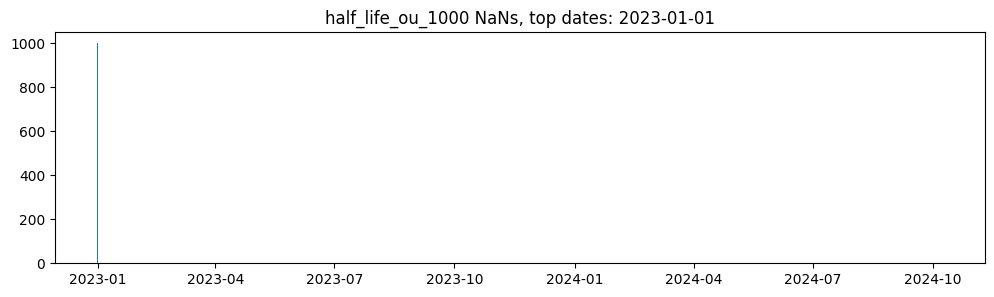

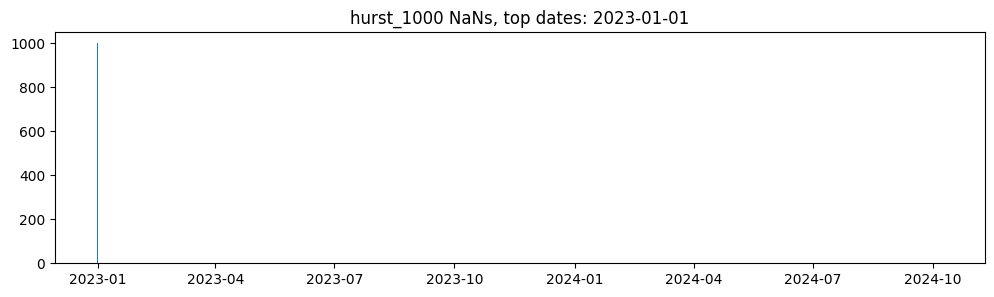

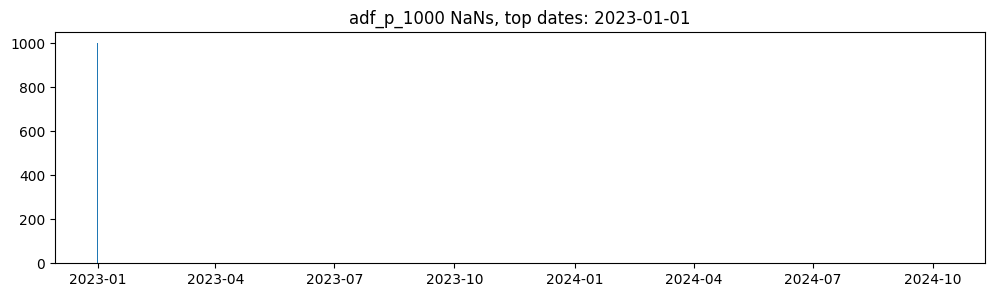

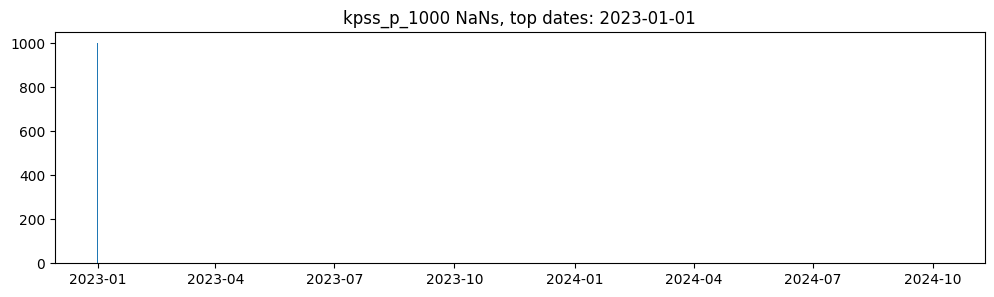

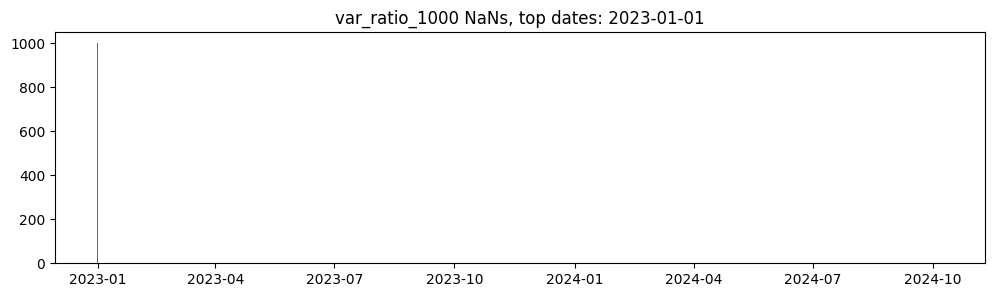

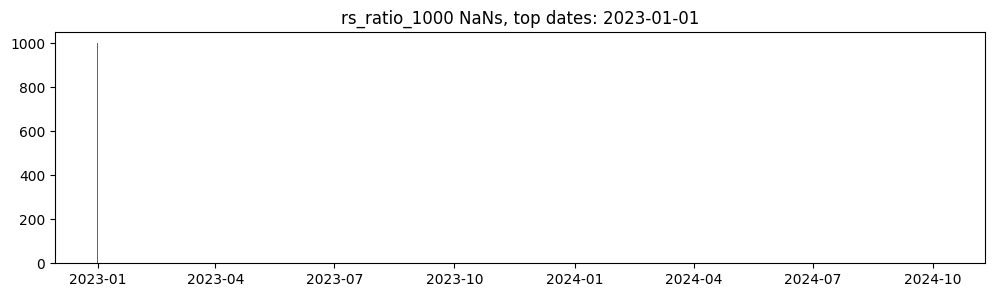

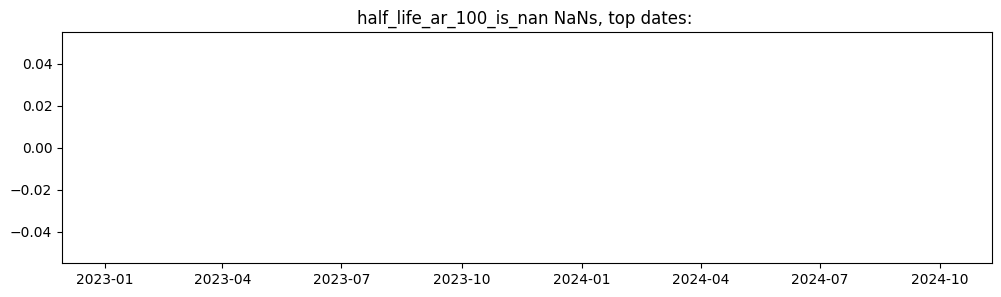

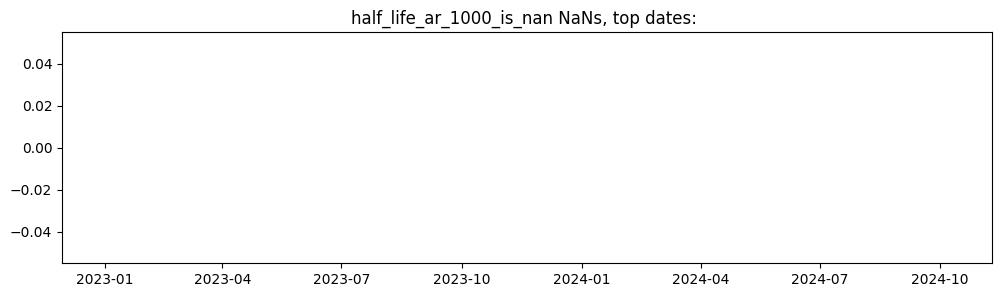

In [13]:
date_index = pd.to_datetime(df.index.date)
for col in df.columns:
    plt.figure(figsize=(12, 3))
    group = df[col].isna().astype("int").groupby(date_index).sum()
    plt.bar(group.index, group.values)
    plt.title(col + " NaNs, top dates: " + ", ".join([str(x) for x in group[group != 0].sort_values(ascending=False)[:5].index.date]))
    plt.show()

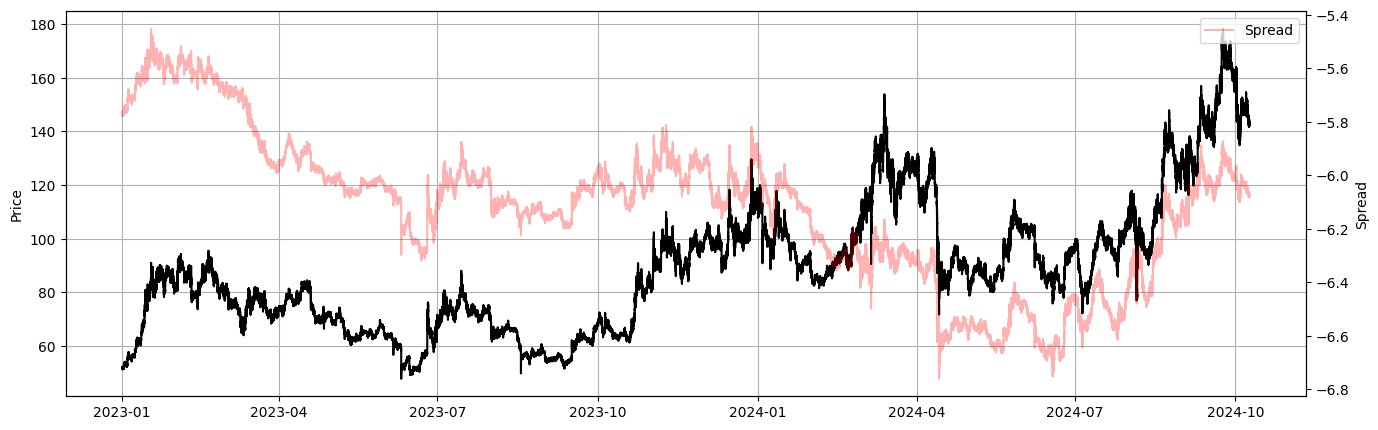

In [14]:
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['close'], c='black')
plt.ylabel('Price')
plt.grid()

ax = plt.twinx()
ax.plot(df.index, df['spread'], c='red', alpha=0.3, label='Spread')
ax.set_ylabel('Spread')
plt.grid(False)
plt.legend(loc='best')

plt.show()

In order to have different kinds of price movements in the test split, let's take the data up to 2024-04 as train/val. This way our test data both has an outset period and strong trend periods.

In [15]:
TEST_START = pd.to_datetime(datetime.datetime(2024, 4, 1))

Convert prices, volumes and spreads to usable features: we replace prices with returns, volumes with log-volumes, spreads with abs(spread)/close.

In [16]:
df['return'] = df['close'].diff(1) / df['close'].shift(1)
df['logvolume'] = np.log1p(df['volume'])
df['relspread'] = np.abs(df['spread']) / df['close']

Create target values for both classification problems, remove the last row as we dont have a target for it.

For the second task, we count std with a window equal to 1 hour (a reasonable window for a statistic that has to meaningfully change with each point while having some sense in it - not too noisy and not too smooth).

In [17]:
df['y1'] = np.where(
    df['spread'].shift(-1) > df['spread'],
    1,
    0
)


df['y2'] = 1 + np.where(
    df['spread'].shift(-1) > df['spread'] + df['spread'].rolling(window=60).std(),
    1,
    np.where(
        df['spread'].shift(-1) < df['spread'] - df['spread'].rolling(window=60).std(),
        -1,
        0
    )
)

df = df.drop(df.tail(1).index)

In [18]:
df.shape

(931679, 28)

# Visual feature analysis

From here on out, we explore only the train+val part of the data:

In [19]:
X_trainval = df[df.index < TEST_START].dropna().iloc[:, 3:-2]
X_test = df[df.index >= TEST_START].dropna().iloc[:, 3:-2]
y1_trainval = df[df.index < TEST_START].dropna()['y1']
y1_test = df[df.index >= TEST_START].dropna()['y1']
y2_trainval = df[df.index < TEST_START].dropna()['y2']
y2_test = df[df.index >= TEST_START].dropna()['y2']

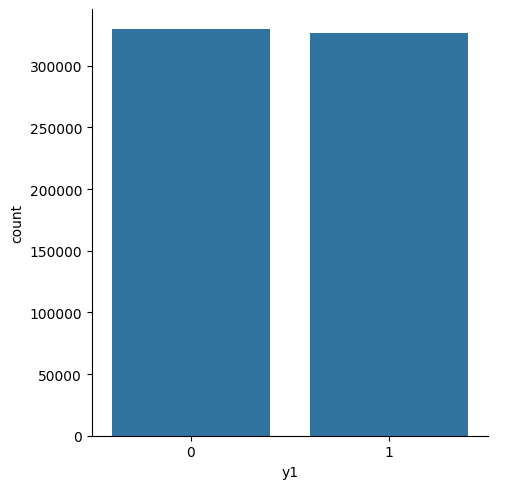

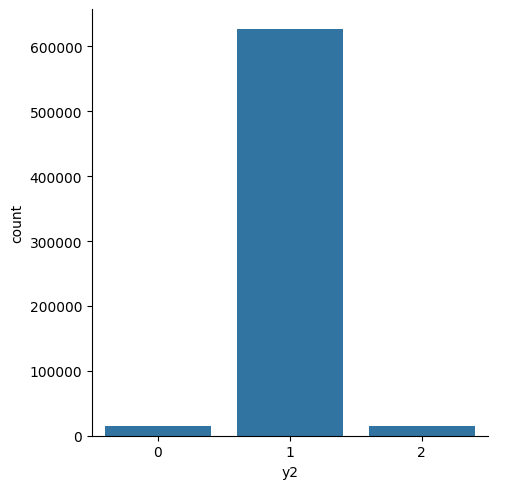

In [20]:
_ = sns.catplot(x=y1_trainval, kind='count')
_ = sns.catplot(x=y2_trainval, kind='count')

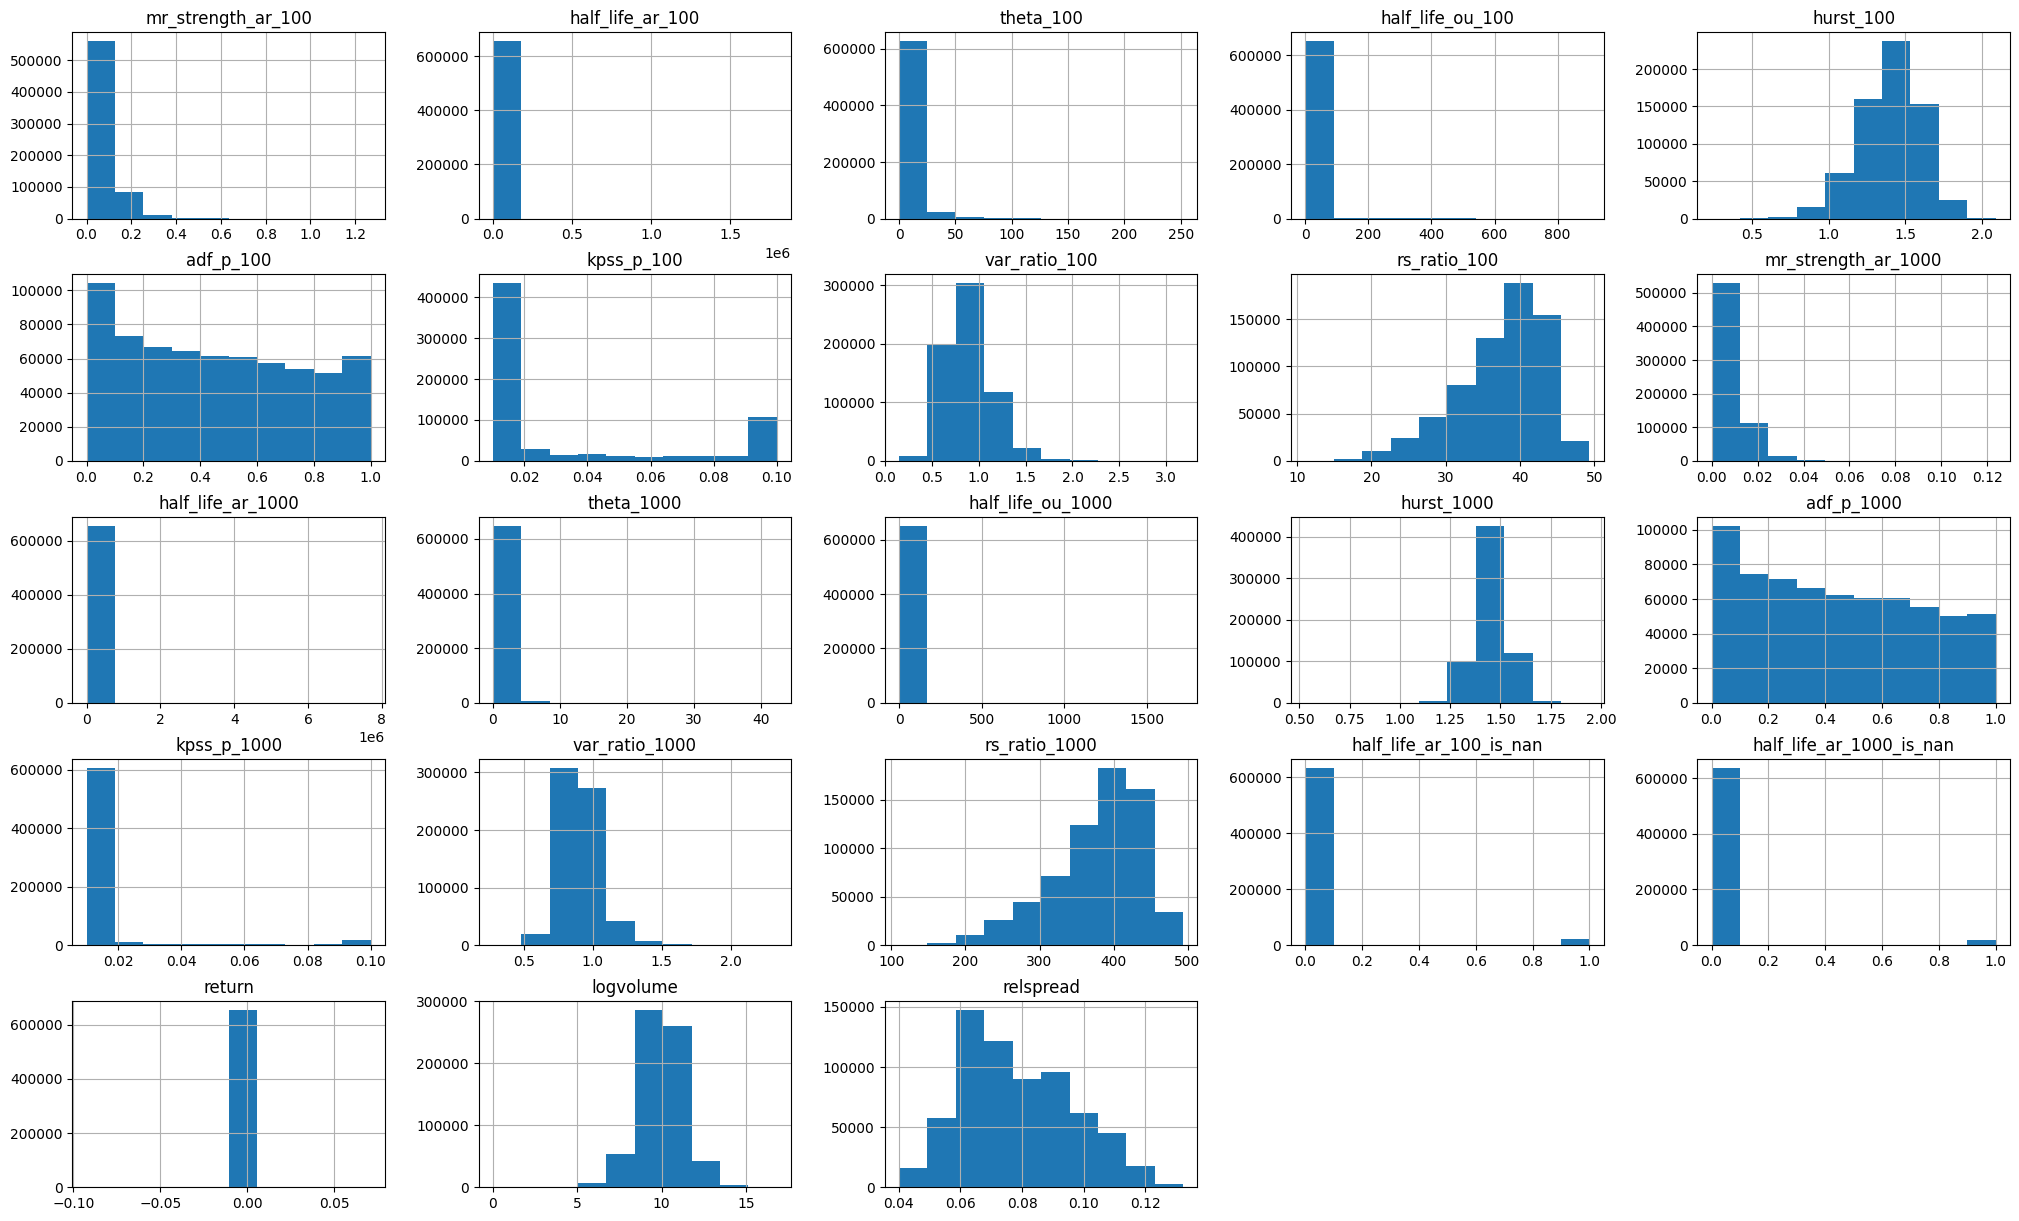

In [21]:
X_trainval.hist(figsize=(25, 15));

We will be working with a linear model and tree-based models. The latter don't depend on monotonous transformations of data, while the former will benefit from applying logarithm to each feature with either big values or heavy-tailed distribution.

In [22]:
col_list = ["mr_strength_ar_100", "half_life_ar_100", "theta_100", "half_life_ou_100", "rs_ratio_100", "mr_strength_ar_1000",
            "half_life_ar_1000", "theta_1000", "half_life_ou_1000", "rs_ratio_1000"]
for col in col_list:
    X_trainval[col] = np.log1p(X_trainval[col])
    X_test[col] = np.log1p(X_test[col])

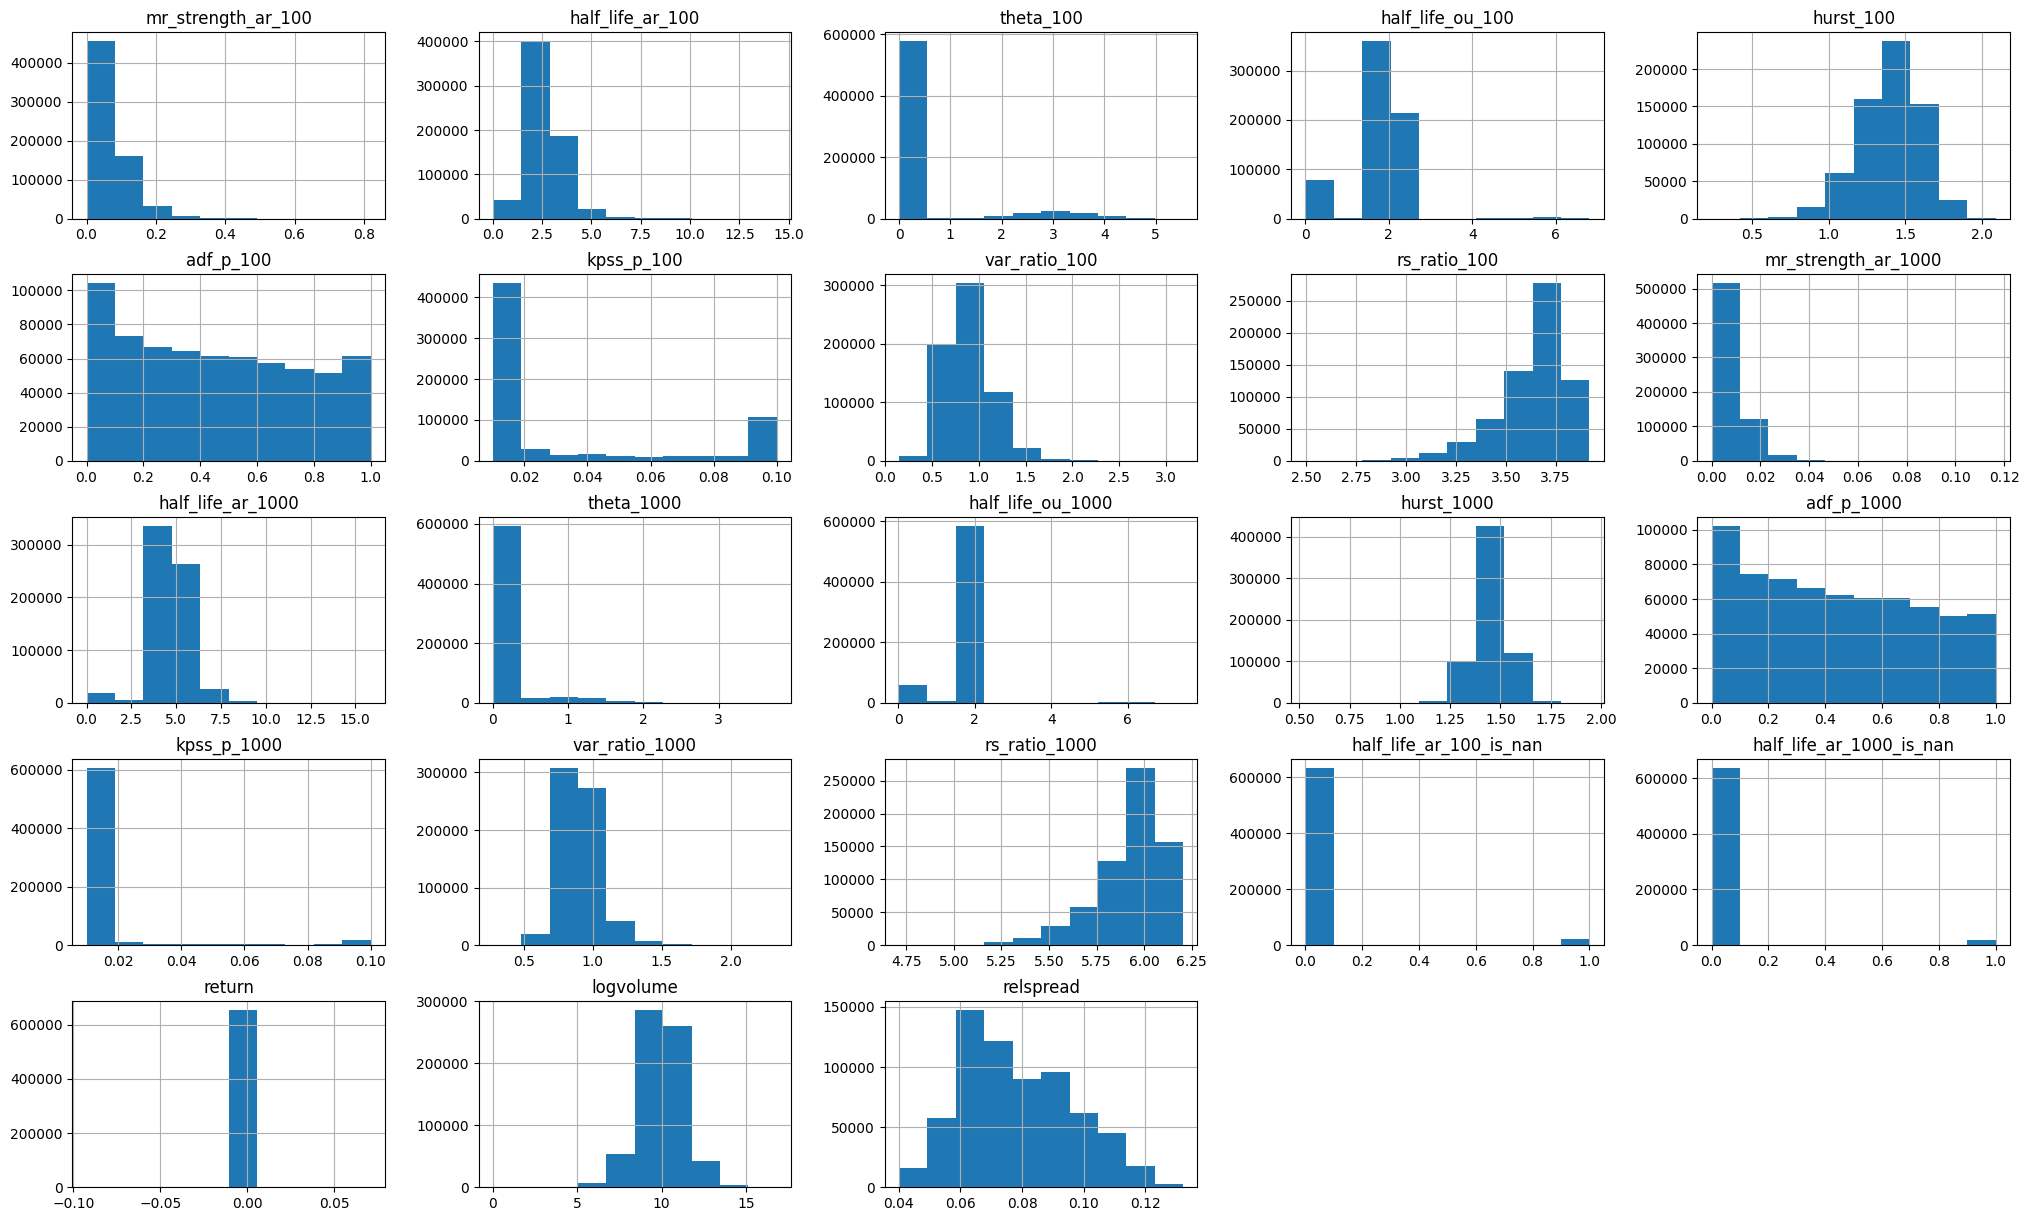

In [23]:
X_trainval.hist(figsize=(25, 15));

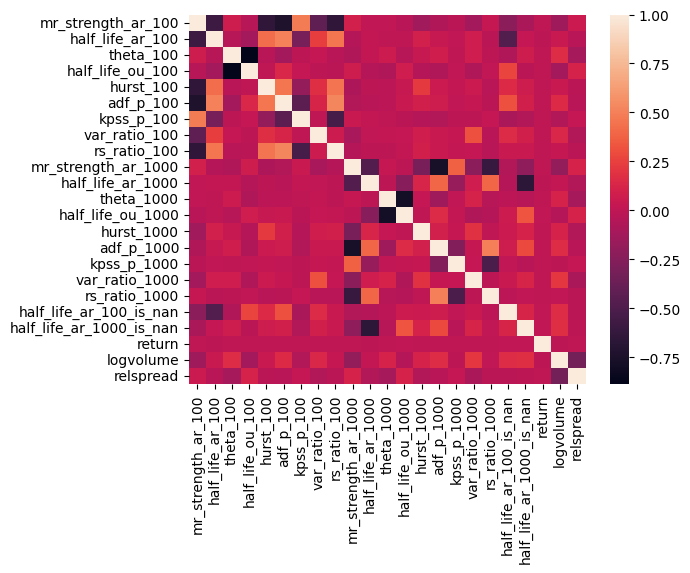

In [24]:
_ = sns.heatmap(X_trainval.corr())

There are heavily correlated features, but not a great amount of them, and not correlated enough for the feature matrix to be close to non-full-ranked.

The training will be layed out as follows: we use TimeSeriesSplit to cross-validate a model on trainval data, calculating macro-average f1-score for both classes (since they are equal in terms of importance, unlike normally in classification tasks, where gt=1 is more important) on each fold for binary classification and mean of ovr-f1-scores for two rare classes 0 and 2 (so that a model that meaningfully tries to predict those rare classes rates higher than a model that constantly predicts the most frequent class) for multi-class classifications. We need to determine the number of splits:

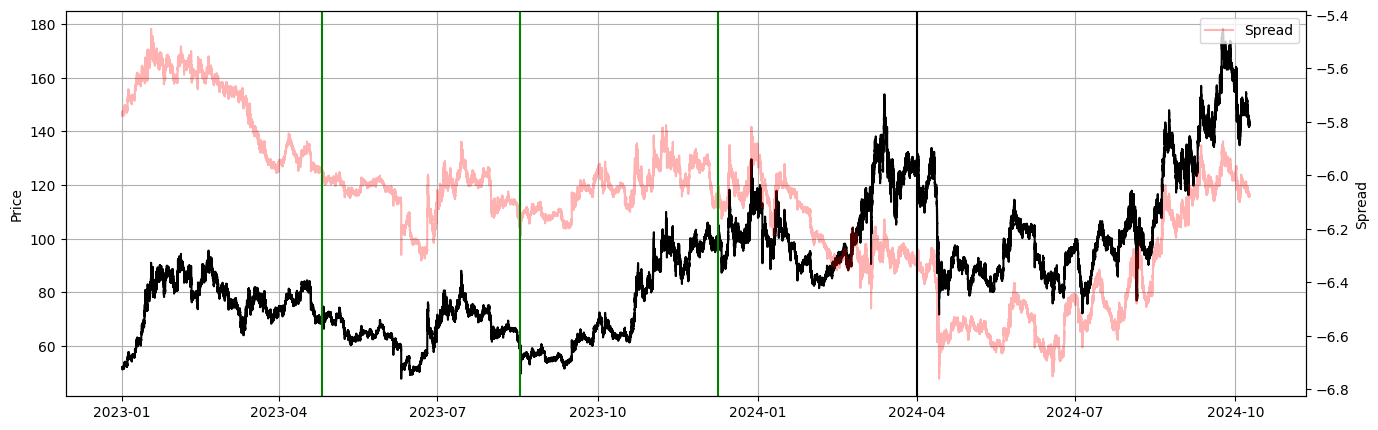

In [25]:
K = 3
cv = model_selection.TimeSeriesSplit(K)

plt.figure(figsize=(16, 5))
plt.plot(df.index, df['close'], c='black')
plt.ylabel('Price')
plt.grid()

ax = plt.twinx()
ax.plot(df.index, df['spread'], c='red', alpha=0.3, label='Spread')
ax.set_ylabel('Spread')
plt.grid(False)
plt.legend(loc='best')

plt.axvline(x=TEST_START, c='black', label='Test split')
for (_, test_idx) in cv.split(X_trainval, y1_trainval):
    plt.axvline(x=X_trainval.index[test_idx[0]], c='green')

plt.show()

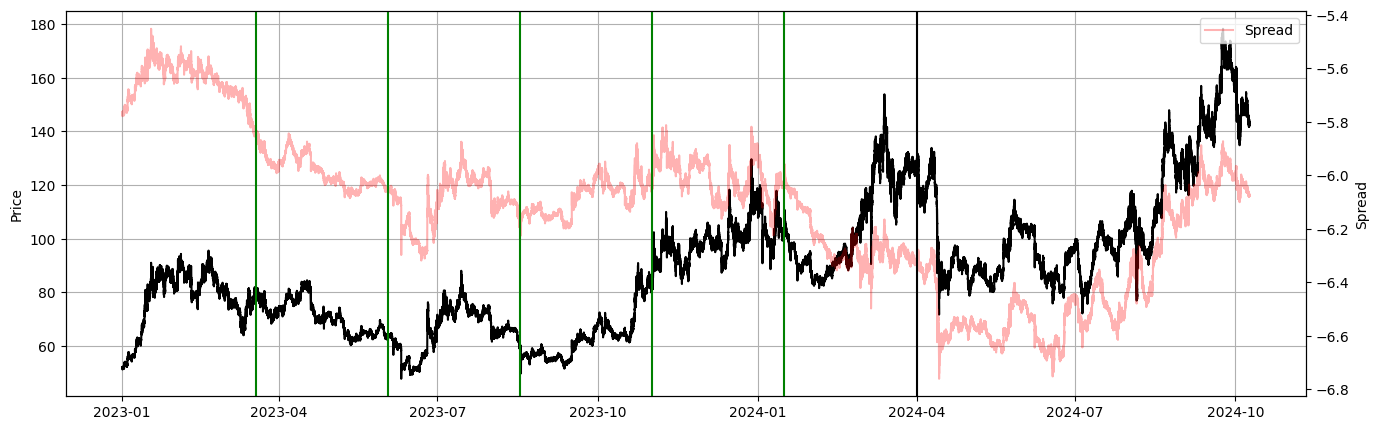

In [26]:
K = 5
cv = model_selection.TimeSeriesSplit(K)

plt.figure(figsize=(16, 5))
plt.plot(df.index, df['close'], c='black')
plt.ylabel('Price')
plt.grid()

ax = plt.twinx()
ax.plot(df.index, df['spread'], c='red', alpha=0.3, label='Spread')
ax.set_ylabel('Spread')
plt.grid(False)
plt.legend(loc='best')

plt.axvline(x=TEST_START, c='black', label='Test split')
for (_, test_idx) in cv.split(X_trainval, y1_trainval):
    plt.axvline(x=X_trainval.index[test_idx[0]], c='green')

plt.show()

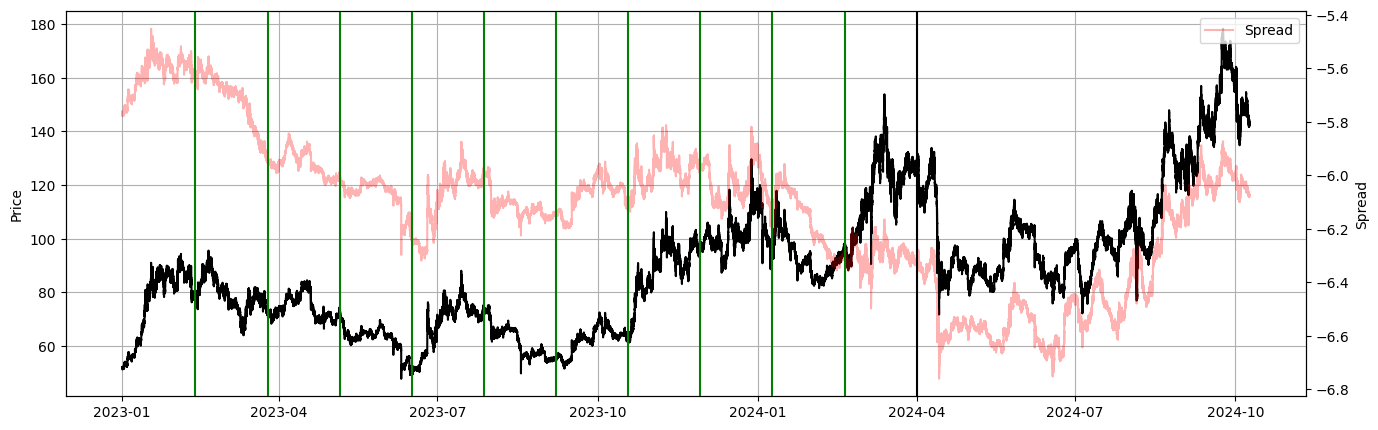

In [27]:
K = 10
cv = model_selection.TimeSeriesSplit(K)

plt.figure(figsize=(16, 5))
plt.plot(df.index, df['close'], c='black')
plt.ylabel('Price')
plt.grid()

ax = plt.twinx()
ax.plot(df.index, df['spread'], c='red', alpha=0.3, label='Spread')
ax.set_ylabel('Spread')
plt.grid(False)
plt.legend(loc='best')

plt.axvline(x=TEST_START, c='black', label='Test split')
for (_, test_idx) in cv.split(X_trainval, y1_trainval):
    plt.axvline(x=X_trainval.index[test_idx[0]], c='green')

plt.show()

Here, it seems that smaller number of splits should better provide the data for different market states, so we take K=3.

In [28]:
K = 3

In [29]:
import collections
import itertools
import tqdm

def calculate_metrics_for_model(cross_val_func, model_func, args):
    ret = []
    for arg_list in tqdm.tqdm(itertools.product(*args.values())):
        kwargs = dict(zip(args.keys(), arg_list))
        model = model_func(**kwargs)
        cur_score = np.mean(cross_val_func(model))
        ret.append(list(arg_list) + [cur_score])
    return pd.DataFrame(ret, columns=list(args.keys())+['score']).sort_values('score', ascending=False)

def binary_scorer(model, X, y):
    return metrics.f1_score(y, model.predict(X), average='macro')

def mult_class_scorer(model, X, y):
    per_class = metrics.f1_score(y, model.predict(X), average=None)
    return (per_class[0] + per_class[2]) / 2

# Baseline Logistic Regression

In [34]:
args = collections.OrderedDict({
    'class_weight': [None, 'balanced'],  # try balancing the classes in binary case as well
    'max_iter': [100, 500, 1000, 5000, 10000, 50000],
    'C': [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval, y1_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=binary_scorer
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="lbfgs failed to converge")
    results_y1 = calculate_metrics_for_model(cross_val_func, linear_model.LogisticRegression, args)

132it [09:18,  4.23s/it]


In [35]:
best_params = {col: results_y1[col].iloc[0] for col in results_y1.columns if col != 'score'}
print(best_params)
results_y1.head()

{'class_weight': 'balanced', 'max_iter': np.int64(50000), 'C': np.float64(0.003)}


,class_weight,max_iter,C,score
121,balanced,50000,0.003,0.499713
88,balanced,1000,0.003,0.499713
99,balanced,5000,0.003,0.499713
66,balanced,100,0.003,0.499713
110,balanced,10000,0.003,0.499713


Unsurprisingly, a simple LogRegression does not generalize to unseen data at all. Now calculate the metric on test data:

In [38]:
model = linear_model.LogisticRegression(**best_params).fit(X_trainval, y1_trainval)
score = binary_scorer(model, X_test, y1_test)
score

0.5017968466877049

In [39]:
print(metrics.classification_report(y1_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.52      0.51    139947
           1       0.49      0.49      0.49    135092

    accuracy                           0.50    275039
   macro avg       0.50      0.50      0.50    275039
weighted avg       0.50      0.50      0.50    275039



Compare that to a model tossing a coin:

In [40]:
metrics.f1_score(y1_test, np.random.choice([0, 1], size=y1_test.shape), average='macro')

0.5003511849466352

In [41]:
print(metrics.classification_report(y1_test, np.random.choice([0, 1], size=y1_test.shape)))

              precision    recall  f1-score   support

           0       0.51      0.50      0.51    139947
           1       0.49      0.50      0.50    135092

    accuracy                           0.50    275039
   macro avg       0.50      0.50      0.50    275039
weighted avg       0.50      0.50      0.50    275039



The difference with a random model is negligible - the only thing the linear model does better is that it more often predicts 0-class, having a marginally better recall on it.

In [42]:
with open('p1_logreg_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

In [43]:
args = collections.OrderedDict({
    'class_weight': ['balanced'],  # here we don't have a choice, only balanced is adequate for the task
    'max_iter': [100, 500, 1000],  # multi-class takes a lot of time, so somewhat lower the number of iterations
    'C': [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval, y2_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=mult_class_scorer,
    n_jobs=-1
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="lbfgs failed to converge")
    results_y2 = calculate_metrics_for_model(cross_val_func, linear_model.LogisticRegression, args)

21it [20:55, 59.77s/it] 


In [44]:
best_params = {col: results_y2[col].iloc[0] for col in results_y2.columns if col != 'score'}
print(best_params)
results_y2.head()

{'class_weight': 'balanced', 'max_iter': np.int64(1000), 'C': np.float64(0.003)}


,class_weight,max_iter,C,score
14,balanced,1000,0.003,0.069902
13,balanced,500,3.000,0.069777
10,balanced,500,0.100,0.069739
17,balanced,1000,0.100,0.069731
11,balanced,500,0.300,0.069730


In [45]:
model = linear_model.LogisticRegression(**best_params).fit(X_trainval, y2_trainval)
score = mult_class_scorer(model, X_test, y2_test)
score

np.float64(0.06642684902581153)

In [46]:
print(metrics.classification_report(y2_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.03      0.24      0.06      5356
           1       0.98      0.66      0.79    263677
           2       0.04      0.40      0.08      6006

    accuracy                           0.64    275039
   macro avg       0.35      0.43      0.31    275039
weighted avg       0.94      0.64      0.76    275039



Here we see that because of the balanced loss, the model vastly overestimates the number of occurences of rare classes, judging by the very low precision. We can not compare to a stupid model predicting only 1, since we defined the metric so that such model scores 0, so let's try instead a coin-toss predicting either 0 or 2:

In [49]:
per_class = metrics.f1_score(y2_test, np.random.choice([0, 2], size=y2_test.shape), average=None)
score = (per_class[0] + per_class[2]) / 2
score

np.float64(0.03971760677406627)

In [51]:
print(metrics.classification_report(y2_test, np.random.choice([0, 2], size=y2_test.shape), zero_division=0))

              precision    recall  f1-score   support

           0       0.02      0.50      0.04      5356
           1       0.00      0.00      0.00    263677
           2       0.02      0.50      0.04      6006

    accuracy                           0.02    275039
   macro avg       0.01      0.33      0.03    275039
weighted avg       0.00      0.02      0.00    275039



Our model is somewhat better in terms of precision, while having a worse recall - unsurprisingly, since the coin-toss model predicts every case as either 0 or 2, while the real model only does so for a fraction of points. Still, the resulting metric is twice as big for LogReg, despite being itself a very low number.

In [52]:
with open('p2_logreg_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

# Tree-based models: Random Forest

Note that there is a perfect way of imputting NaNs for tree-based models: setting them to large value way off the main data distribution. In our case, the only features affected heavily are the two half_life_ar features, for which we created a binary is_nan variable, which provides the model with the same possibility of separating all the NaN values in a single split.

In [53]:
args = collections.OrderedDict({
    'class_weight': ['balanced_subsample'], # balance the classes for each tree depending only on the data it receives
    'n_jobs': [-1],
    'n_estimators': [100, 50, 20],
    'min_samples_split': [0.002, 0.005, 0.01, 0.02],
    'min_samples_leaf': [0.00001, 0.0001, 0.001]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval, y1_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=binary_scorer
)
results_y1 = calculate_metrics_for_model(cross_val_func, ensemble.RandomForestClassifier, args)

36it [52:07, 86.88s/it] 


In [55]:
best_params = {col: results_y1[col].iloc[0] for col in results_y1.columns if col != 'score'}
print(best_params)
results_y1.head()

{'class_weight': 'balanced_subsample', 'n_jobs': np.int64(-1), 'n_estimators': np.int64(100), 'min_samples_split': np.float64(0.02), 'min_samples_leaf': np.float64(0.001)}


,class_weight,n_jobs,n_estimators,min_samples_split,min_samples_leaf,score
11,balanced_subsample,-1,100,0.020,0.0010,0.507649
23,balanced_subsample,-1,50,0.020,0.0010,0.507200
16,balanced_subsample,-1,50,0.005,0.0001,0.507001
28,balanced_subsample,-1,20,0.005,0.0001,0.506781
7,balanced_subsample,-1,100,0.010,0.0001,0.506758


This model is still negligibly better than the random one, though by a larger margin than LogReg.

In [56]:
model = ensemble.RandomForestClassifier(**best_params).fit(X_trainval, y1_trainval)
score = binary_scorer(model, X_test, y1_test)
score

0.5020556330843651

In [57]:
print(metrics.classification_report(y1_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.60      0.55    139947
           1       0.50      0.41      0.45    135092

    accuracy                           0.51    275039
   macro avg       0.51      0.51      0.50    275039
weighted avg       0.51      0.51      0.50    275039



In [58]:
with open('p1_randomforest_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

The resulting test metric is basically the same, with a more skewed score towards the 0-class because of a much worse recall for the 1-class.

In [59]:
args = collections.OrderedDict({
    'class_weight': ['balanced_subsample'], # balance the classes for each tree depending only on the data it receives
    'n_jobs': [-1],
    'n_estimators': [100, 50, 20],
    'min_samples_split': [0.005, 0.01, 0.02, 0.05],
    'min_samples_leaf': [0.00001, 0.0001, 0.001]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval, y2_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=mult_class_scorer
)

results_y2 = calculate_metrics_for_model(cross_val_func, ensemble.RandomForestClassifier, args)

36it [30:12, 50.34s/it]


In [60]:
best_params = {col: results_y2[col].iloc[0] for col in results_y2.columns if col != 'score'}
print(best_params)
results_y2.head()

{'class_weight': 'balanced_subsample', 'n_jobs': np.int64(-1), 'n_estimators': np.int64(100), 'min_samples_split': np.float64(0.005), 'min_samples_leaf': np.float64(0.0001)}


,class_weight,n_jobs,n_estimators,min_samples_split,min_samples_leaf,score
1,balanced_subsample,-1,100,0.005,0.00010,0.072262
12,balanced_subsample,-1,50,0.005,0.00001,0.072029
2,balanced_subsample,-1,100,0.005,0.00100,0.071940
0,balanced_subsample,-1,100,0.005,0.00001,0.071804
3,balanced_subsample,-1,100,0.010,0.00001,0.071491


In [61]:
model = ensemble.RandomForestClassifier(**best_params).fit(X_trainval, y2_trainval)
score = mult_class_scorer(model, X_test, y2_test)
score

np.float64(0.07063782002816046)

In [62]:
print(metrics.classification_report(y2_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.04      0.31      0.07      5356
           1       0.98      0.66      0.79    263677
           2       0.04      0.37      0.07      6006

    accuracy                           0.65    275039
   macro avg       0.35      0.45      0.31    275039
weighted avg       0.94      0.65      0.76    275039



Multi-class RandomForest works basically the same as LogReg, with a bit more uniform metric distribution between the meaningful classes.

In [63]:
with open('p2_randomforest_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

# Gradient Boosting

In [48]:
args = collections.OrderedDict({
    'auto_class_weights': ['Balanced'],
    'task_type': ['GPU'],
    'verbose': [False],
    'iterations': [3000, 2000, 1000, 500],
    'learning_rate': [None, 0.3, 0.1, 0.03],
    'depth': [4, 5, 6]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval, y1_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=binary_scorer
)
results_y1 = calculate_metrics_for_model(cross_val_func, catboost.CatBoostClassifier, args)

48it [1:29:42, 112.14s/it]


In [49]:
best_params = {col: results_y1[col].iloc[0] for col in results_y1.columns if col != 'score'}
print(best_params)
results_y1.head()

{'auto_class_weights': 'Balanced', 'task_type': 'GPU', 'verbose': False, 'iterations': 2000, 'learning_rate': nan, 'depth': 5}


,auto_class_weights,task_type,verbose,iterations,learning_rate,depth,score
13,Balanced,GPU,False,2000,NaN,5,0.506951
45,Balanced,GPU,False,500,0.03,4,0.506939
47,Balanced,GPU,False,500,0.03,6,0.506763
33,Balanced,GPU,False,1000,0.03,4,0.506723
1,Balanced,GPU,False,3000,NaN,5,0.506704


In [56]:
if ('learning_rate' in best_params) and np.isnan(best_params['learning_rate']):
    del best_params['learning_rate']  # nan means the model takes the default None value

In [59]:
best_params['verbose'] = bool(best_params['verbose'])
best_params

{'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'verbose': False,
 'iterations': 2000,
 'depth': 5}

In [60]:
model = catboost.CatBoostClassifier(**best_params).fit(X_trainval, y1_trainval)
score = binary_scorer(model, X_test, y1_test)
score

0.5039144960828941

In [61]:
print(metrics.classification_report(y1_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53    139947
           1       0.50      0.45      0.47    135092

    accuracy                           0.51    275039
   macro avg       0.50      0.50      0.50    275039
weighted avg       0.50      0.51      0.50    275039



In [62]:
with open('p1_catboost_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

Cross-validation score is worse for Catboost than RandomForest, probably because gradient boosting is much more prone to overfitting than random forest is. Still, evaluation on the test split gives a marginally better score.

In [63]:
# remove the learning rate variation, relying on the package to estimate it by itself,
# since such setting was the best on the first problem
args = collections.OrderedDict({
    'auto_class_weights': ['Balanced'],
    'task_type': ['GPU'],
    'verbose': [False],
    'iterations': [4000, 3000, 2000, 1000, 500],
    'depth': [4, 5, 6, 7]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval, y2_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=mult_class_scorer
)

results_y2 = calculate_metrics_for_model(cross_val_func, catboost.CatBoostClassifier, args)

20it [1:03:33, 190.67s/it]


In [64]:
best_params = {col: results_y2[col].iloc[0] for col in results_y2.columns if col != 'score'}
print(best_params)
results_y2.head()

{'auto_class_weights': 'Balanced', 'task_type': 'GPU', 'verbose': False, 'iterations': 4000, 'depth': 6}


,auto_class_weights,task_type,verbose,iterations,depth,score
2,Balanced,GPU,False,4000,6,0.073248
1,Balanced,GPU,False,4000,5,0.073083
10,Balanced,GPU,False,2000,6,0.072886
6,Balanced,GPU,False,3000,6,0.072508
5,Balanced,GPU,False,3000,5,0.072492


In [65]:
best_params['verbose'] = bool(best_params['verbose'])
best_params

{'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'verbose': False,
 'iterations': 4000,
 'depth': 6}

In [66]:
model = catboost.CatBoostClassifier(**best_params).fit(X_trainval, y2_trainval)
score = mult_class_scorer(model, X_test, y2_test)
score

0.07417805817736409

In [67]:
print(metrics.classification_report(y2_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.04      0.27      0.07      5356
           1       0.97      0.76      0.85    263677
           2       0.05      0.26      0.08      6006

    accuracy                           0.74    275039
   macro avg       0.35      0.43      0.33    275039
weighted avg       0.94      0.74      0.82    275039



In [68]:
with open('p2_catboost_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

In multiclass case, once again gradient boosting is slightly better than random forest. In terms of precision/recall it is much worse by recall while being marginally better by precision, which together result in the slightly higher f1-score.

# Adding new features

We are given features for moving windows 100 and 1000 minutes. To add as much new information as possible, we will create additional features for the window list of (15, 60, 240) minutes. The first obvious group of features to add are exponential moving means and stds of returns, logvolumes and relspreads:

In [30]:
for span in [15, 60, 240]:
    for col in ['return', 'logvolume', 'relspread']:
        df[f'{col}_{span}_mean'] = df[col].ewm(span=span).mean()
        df[f'{col}_{span}_std'] = df[col].ewm(span=span).std()

The next step is to add technical indicators as features. We are calculating them both for the close price and for the spread, which might be a bit of a stretch. The first one, of course, is RSI:

In [31]:
def SMMA(s, n):
    """
    Leftover implementation from a previous project.
    IIRC, tradingview.com implements it like this.
    """
    return pd.Series(s).ewm(alpha=1/n).mean()

def RSI(s, n=14):
    """https://en.wikipedia.org/wiki/Relative_strength_index"""
    s = pd.Series(s)
    U = SMMA(np.maximum(s - s.shift(1), 0), n)
    D = SMMA(np.maximum(s.shift(1) - s, 0), n)
    return U / (U + D + 1e-25)

In [32]:
for span in [15, 60, 240]:
    for col in ['close', 'spread']:
        df[f'{col}_{span}_rsi'] = RSI(df[col], span)

Add another two common oscillators: MACD and TSI. Note that for indicators requiring two time windows we set the shorter one to half of the longer one. Also note that MACD is a simple difference of two moving averages - adding it could make the features close to linearly dependent, but as we are currently working with tree-based models, it is not a big deal. Also, trees in particular benefit from adding linear combinations of features as new ones, since by default they can only split the space by one feature at a time. If we were working with linear or neural models, though, it would be important and would require addressing.

In [33]:
def EMA(s, n):
    return pd.Series(s).ewm(span=n).mean()

def MACD(s, n_short, n_long):
    """https://www.investopedia.com/terms/m/macd.asp"""
    s = pd.Series(s)
    return EMA(s, n_short) - EMA(s, n_long)

def TSI(s, n_short, n_long):
    """https://chartschool.stockcharts.com/table-of-contents/technical-indicators-and-overlays/technical-indicators/true-strength-index"""
    s = pd.Series(s)
    PC = EMA(EMA(s - s.shift(1), n_long), n_short)
    APC = EMA(EMA(np.abs(s - s.shift(1)), n_long), n_short)
    return PC / (APC + 1e-25)

In [34]:
for span in [15, 60, 240]:
    for col in ['close', 'spread']:
        df[f'{col}_{span}_macd'] = MACD(df[col], np.ceil(span/2), span)
        df[f'{col}_{span}_tsi'] = TSI(df[col], np.ceil(span/2), span)

Calculate Bollinger Bands and add %b and Bollinger Bandwidth:

In [36]:
def BB_indicator(s, n, k=2):
    """https://en.wikipedia.org/wiki/Bollinger_Bands"""
    s = pd.Series(s)
    UB = s.rolling(n).mean() + k * s.rolling(n).std()
    LB = s.rolling(n).mean() - k * s.rolling(n).std()
    percent_B = (s - LB) / (UB - LB + 1e-25)
    bandwidth_B = 2 * (UB - LB) / (UB + LB)
    return percent_B, bandwidth_B

In [37]:
for span in [15, 60, 240]:
    for col in ['close', 'spread']:
        df[f'{col}_{span}_percb'], df[f'{col}_{span}_bandb'] = \
            BB_indicator(df[col], span)

Finally, add MFI as a volume indicator, both for the volume itself and for logvolume:

In [64]:
def MFI(v, s, n):
    """
    https://www.investopedia.com/terms/m/mfi.asp
    Substitute Typical Price with just Close
    """
    s = pd.Series(s)
    v = pd.Series(v)
    RMF = s * v
    PMF = pd.Series(np.where(
        s - s.shift(1) > 0,
        RMF, 0
    )).rolling(n).mean()
    NMF = pd.Series(np.where(
        s - s.shift(1) < 0,
        RMF, 0
    )).rolling(n).mean()
    return np.array(PMF / (PMF + NMF + 1e-25))

In [65]:
for span in [15, 60, 240]:
    for col in ['volume', 'logvolume']:
        df[f'{col}_{span}_mfi'] = MFI(df[col], df['close'], span)

In total we added 54 features, compared to 23 we had initially. Create new training and testing matrices:

In [67]:
X_trainval_ext = df[df.index < TEST_START].dropna().drop(['close', 'volume', 'spread', 'y1', 'y2'], axis=1)
X_test_ext = df[df.index >= TEST_START].dropna().drop(['close', 'volume', 'spread', 'y1', 'y2'], axis=1)

# Gradient Boosting with additional features

Now try training the model on the new data:

In [71]:
args = collections.OrderedDict({
    'auto_class_weights': ['Balanced'],
    'task_type': ['GPU'],
    'verbose': [False],
    'iterations': [4000, 2000, 1000],
    'depth': [4, 5, 6]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval_ext, y1_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=binary_scorer
)
results_y1 = calculate_metrics_for_model(cross_val_func, catboost.CatBoostClassifier, args)

9it [33:09, 221.06s/it]


In [72]:
best_params = {col: results_y1[col].iloc[0] for col in results_y1.columns if col != 'score'}
print(best_params)
results_y1.head()

{'auto_class_weights': 'Balanced', 'task_type': 'GPU', 'verbose': False, 'iterations': 2000, 'depth': 5}


,auto_class_weights,task_type,verbose,iterations,depth,score
4,Balanced,GPU,False,2000,5,0.516558
0,Balanced,GPU,False,4000,4,0.516487
5,Balanced,GPU,False,2000,6,0.516476
6,Balanced,GPU,False,1000,4,0.516410
3,Balanced,GPU,False,2000,4,0.516305


In [73]:
best_params['verbose'] = bool(best_params['verbose'])
best_params

{'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'verbose': False,
 'iterations': 2000,
 'depth': 5}

In [74]:
model = catboost.CatBoostClassifier(**best_params).fit(X_trainval_ext, y1_trainval)
score = binary_scorer(model, X_test_ext, y1_test)
score

0.5104726651267337

In [75]:
print(metrics.classification_report(y1_test, model.predict(X_test_ext)))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55    139947
           1       0.51      0.44      0.47    135092

    accuracy                           0.51    275039
   macro avg       0.51      0.51      0.51    275039
weighted avg       0.51      0.51      0.51    275039



In [76]:
with open('p1_catboost_addfeatures_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

The model trained with additional features performs noticably better, still having the disproportionately bad f1-score for the 1-class.

In [77]:
args = collections.OrderedDict({
    'auto_class_weights': ['Balanced'],
    'task_type': ['GPU'],
    'verbose': [False],
    'iterations': [5000, 4000, 3000],
    'depth': [7, 6, 5]
})
cross_val_func = lambda m: model_selection.cross_val_score(
    m,
    X_trainval_ext, y2_trainval,
    cv=model_selection.TimeSeriesSplit(K),
    scoring=mult_class_scorer
)

results_y2 = calculate_metrics_for_model(cross_val_func, catboost.CatBoostClassifier, args)

9it [1:34:09, 627.68s/it]


In [78]:
best_params = {col: results_y2[col].iloc[0] for col in results_y2.columns if col != 'score'}
print(best_params)
results_y2.head()

{'auto_class_weights': 'Balanced', 'task_type': 'GPU', 'verbose': False, 'iterations': 5000, 'depth': 6}


,auto_class_weights,task_type,verbose,iterations,depth,score
1,Balanced,GPU,False,5000,6,0.103093
4,Balanced,GPU,False,4000,6,0.102898
7,Balanced,GPU,False,3000,6,0.102337
2,Balanced,GPU,False,5000,5,0.097755
6,Balanced,GPU,False,3000,7,0.097623


In [79]:
best_params['verbose'] = bool(best_params['verbose'])
best_params

{'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'verbose': False,
 'iterations': 5000,
 'depth': 6}

In [80]:
model = catboost.CatBoostClassifier(**best_params).fit(X_trainval_ext, y2_trainval)
score = mult_class_scorer(model, X_test_ext, y2_test)
score

0.09486447698476423

In [81]:
print(metrics.classification_report(y2_test, model.predict(X_test_ext)))

              precision    recall  f1-score   support

           0       0.05      0.30      0.09      5356
           1       0.98      0.79      0.87    263677
           2       0.06      0.32      0.10      6006

    accuracy                           0.77    275039
   macro avg       0.36      0.47      0.35    275039
weighted avg       0.94      0.77      0.84    275039



In [82]:
with open('p2_catboost_addfeatures_bparams.pkl', 'wb') as inf:
    pickle.dump(best_params, inf)

All metrics are somewhat better than the model trained without the new features, unsurprisingly. Still, the precision on the informative classes is very low, which means that the model tries to overpredict the classes to guess at least some of their occurences correctly.

# Results

Compare all four resulting models and coin-toss:

In [109]:
def model_metric_comparison(gt, pred_dict, metric_lst, calc_macro_over):
    ret = {}
    for name, preds in pred_dict.items():
        ret[name] = {}
        for m in metric_lst:
            metric_values = m(gt, preds, average=None, zero_division=0)
            for label, metric_val in enumerate(metric_values):
                if label not in calc_macro_over:
                    continue
                ret[name][m.__name__.replace('_score', '')+f'_{label}'] = metric_val
            ret[name][m.__name__.replace('_score', '')+'_mean'] = np.mean([metric_values[i] for i in calc_macro_over])
    return pd.DataFrame.from_dict(ret, orient='index')

### Task 1

In [87]:
metric_lst = [metrics.precision_score, metrics.recall_score, metrics.f1_score]
pred_dict = {}
pred_dict['coin'] = np.random.choice([0, 1], size=y1_test.shape) 

with open('p1_logreg_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['logreg'] = linear_model.LogisticRegression(**best_params) \
        .fit(X_trainval, y1_trainval).predict(X_test)

with open('p1_randomforest_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['randomforest'] = ensemble.RandomForestClassifier(**best_params) \
        .fit(X_trainval, y1_trainval).predict(X_test)

with open('p1_catboost_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['catboost'] = catboost.CatBoostClassifier(**best_params) \
        .fit(X_trainval, y1_trainval).predict(X_test)

with open('p1_catboost_addfeatures_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['catboost_feat'] = catboost.CatBoostClassifier(**best_params) \
        .fit(X_trainval_ext, y1_trainval).predict(X_test_ext)

In [106]:
metrics_df = model_metric_comparison(y1_test, pred_dict, metric_lst, [0, 1])
metrics_df = metrics_df.reindex(sorted(metrics_df.columns), axis=1)
metrics_df.round(3)

,f1_0,f1_1,f1_mean,precision_0,precision_1,precision_mean,recall_0,recall_1,recall_mean
coin,0.505,0.495,0.500,0.509,0.491,0.500,0.501,0.499,0.500
logreg,0.514,0.490,0.502,0.511,0.493,0.502,0.517,0.486,0.502
randomforest,0.554,0.451,0.503,0.514,0.499,0.506,0.601,0.411,0.506
catboost,0.533,0.475,0.504,0.513,0.496,0.505,0.553,0.456,0.505
catboost_feat,0.552,0.469,0.511,0.520,0.506,0.513,0.589,0.437,0.513


While each model is increasingly better in terms of the main metric (f1_mean), note that complex tree-based models skew the recalls heavily towards 0-class, with the worst skew for randomforest. The only model with precision over 50% on 1-class is the most complex one, and it pays for that with second-lowest recall on 1-class.

A way to fix such metric skewness toward 0-class could be to redefine the metric averaging, taking the one which more heavily penalizes the difference between the values - harmonic mean instead of regular mean, for example.

### Task 2

In [107]:
metric_lst = [metrics.precision_score, metrics.recall_score, metrics.f1_score]
pred_dict = {}
pred_dict['coin'] = np.random.choice([0, 2], size=y2_test.shape) 

with open('p2_logreg_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['logreg'] = linear_model.LogisticRegression(**best_params) \
        .fit(X_trainval, y2_trainval).predict(X_test)

with open('p2_randomforest_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['randomforest'] = ensemble.RandomForestClassifier(**best_params) \
        .fit(X_trainval, y2_trainval).predict(X_test)

with open('p2_catboost_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['catboost'] = catboost.CatBoostClassifier(**best_params) \
        .fit(X_trainval, y2_trainval).predict(X_test)

with open('p2_catboost_addfeatures_bparams.pkl', 'rb') as inf:
    best_params = pickle.load(inf)
    pred_dict['catboost_feat'] = catboost.CatBoostClassifier(**best_params) \
        .fit(X_trainval_ext, y2_trainval).predict(X_test_ext)

In [112]:
metrics_df = model_metric_comparison(y2_test, pred_dict, metric_lst, [0, 2])
metrics_df = metrics_df.reindex(sorted(metrics_df.columns), axis=1)
metrics_df.round(3)

,f1_0,f1_2,f1_mean,precision_0,precision_2,precision_mean,recall_0,recall_2,recall_mean
coin,0.037,0.042,0.040,0.019,0.022,0.021,0.498,0.501,0.499
logreg,0.056,0.077,0.066,0.032,0.043,0.037,0.240,0.403,0.321
randomforest,0.066,0.074,0.070,0.037,0.041,0.039,0.296,0.376,0.336
catboost,0.071,0.077,0.074,0.041,0.045,0.043,0.268,0.264,0.266
catboost_feat,0.091,0.099,0.095,0.054,0.058,0.056,0.301,0.322,0.311


Once again, each model is increasingly better in terms of the main metric. In this case, while overall the values are much lower, only two models have a problem with recall skewness. Here, however, the main problem is very low precision - all the models vastly overpredict both informative classes, while still having low recall.

An attempt at fixing this issue could be to train separate binary classification models for each of the two classes and to work with the scores they predict to adjust the threshold - something that is impossible in the case of multi-class classification. Still, adjusting the threshold to increase the precision would decrease the recall, but at least that way it would be possible to determine the best relation between them.